<h1 style="property:value; background-color:skyblue;" align="center"> TS Forecasting Methods

In [1]:
# Basic libraries
import os
import scipy
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import plotly.io as pio
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode
from warnings import catch_warnings, filterwarnings

# Forecasting
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.theta import ThetaForecaster
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Detrender
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sktime.forecasting.base import ForecastingHorizon
from sklearn.linear_model import LinearRegression, Lasso
from sktime.forecasting.compose import make_reduction
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError, mean_absolute_percentage_error
from pmdarima.arima import auto_arima, ARIMA
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.forecasting.theta import ThetaModel

# Set some display options:
pio.templates.default = "plotly_white"
plt.style.use('seaborn-whitegrid')
init_notebook_mode(connected=True)
%matplotlib inline

# Helper function
from forecast_utils import (neighbor_cells, divide_data, EXP_Smoothing, plot_errors, forecasting, 
                            VAR_model, dict_to_dataframe, ts_decomposition, create_acf_pacf, 
                            MLP_Forecasting, plot_forecasting, plot_line, seasonal_decompose, 
                            create_corr_plot, plot_hist,  test_stationarity, errors_box)
from evaluations import nrmse, mape

#### Import the data

In [10]:
full_data = np.load('full_data_imputed.npy')

In [11]:
# Exclude the last 10 days !!
full_data = full_data[:(62-10)*144, :, :, :]

#### Forecasting Methods:
 - Statistical methods:
    - Common Approaches:
        - Trend, Seasonal, Residual Decompositions:
            - Seasonal Extraction in ARIMA Time Series (SEATS).
            - Seasonal and Trend decomposition using Loess (STL). 
            - Exponential smoothing:
                - Single Exponential Smoothing, or SES, for univariate data without trend or seasonality.
                - Double Exponential Smoothing for univariate data with support for trends.
                - Triple Exponential Smoothing, or Holt-Winters Exponential Smoothing, with support for both trends and seasonality.(TES)

        - Autoregressive Models (AR).
        - Moving Average Models (MA).
    - Box–Jenkins Approaches: 
        - ARIMA.
        - SARIMA.
        
- Machine Learning Methods
    - KNN.
    - SVR.
    - LR.
    - ElasticNet.
    - Lasso.
    
- Deep Learning Methods:
    - MLP.
    - CNN.
    - LSTM.
        
## If time-series has:
- No trend, no seasonality and is stationary:
    - Moving Average
    - Simple exp smoothing
- Trend only:
    - Double exp smoothing (TS must be stationary)
    - ARIMA
- Trend and seasonality:
    - Triple exp smoothing (TS must be stationary)
    - SARIMA
- Trend, seasonality and holiday effects:
    - FbProphet
- Effect of external variables:
    - FbProphet
    - ML models
    - DL models
        - MLP
        - CNN
        - LSTM
        - Conv-LSTM
        
- But SARIMA and Smothing mrthodes have some issues:
    - Good for one step or short term forecasts, but not for long term forecasts
    - Works for uni-variate data with linear relationships
    - Focus on temporal dependence only. It does not consider events like holidays, promotions.

So we can apply seasonal adjustment first before forecasting with statistical methods.<br>

#### Forecasting with decomposition:

Seasonal adjustment or deseasonalization is a statistical method for removing the seasonal component of a time series in order to avoid the effects of seasonal comonent of the TS we can forecast a decomposed version of the data.

This can improve the performance of modeling:

- **Clearer Signal:** Identifying and removing the seasonal component from the time series can result in a clearer relationship
between input and output variables.
- **More Information:** Additional information about the seasonal component of the time series can provide new information to improve model performance.

Steps:
- Apply Seasonal adjustment.
- Forecast the componsents separately:
    - Forecast the seasonal component **S(t)**.
    - Forecast the seasonally adjusted component, **R(t) + T(t)**.<br> 
- Reseasonalize 

Now we have a seasonal stationary TS, and to forecast the seasonally adjusted component, any non-seasonal forecasting method may be used. <br>
    
References:
- <a href="https://otexts.com/fpp2/forecasting-decomposition.html">Forecasting Decomposition</a>
- <a href="https://en.wikipedia.org/wiki/Seasonal_adjustment">Seasonal adjustment</a>
- <a href="https://robjhyndman.com/papers/ComplexSeasonality.pdf">Complex Seasonality</a>
- <a href="https://otexts.com/fpp2/complexseasonality.html">Complex Seasonality</a>
- <a href="https://www.mdpi.com/2673-4591/5/1/42/pdf">STL with Statistical and ML methods</a>
- <a href="https://otexts.com/fpp2/complexseasonality.html">Complex Seasonality</a>

<img src="Forecasting FlowChart.gif"><a href="https://people.duke.edu/~rnau/411flow.gif">Source</a></img>

### Dealing only with 9 grids.
| GRID Number | X Position | Y Position|
| --- | --- | --- |
| 1 | 50 | 56 |
| 2 | 50 | 57 |
| 3 | 50 | 58 |
| 4 | 51 | 56 |
| 5 | 51 | 57 |
| 6 | 51 | 58 |
| 7 | 52 | 56 |
| 8 | 52 | 57 |
| 9 | 52 | 58 |

In [12]:
# data = neighbor_cells(data=full_data, 
#                       neighbor_radius=1, 
#                       cell_center=(51,57),
#                       uni_variant=False).set_index('time')

# dic = {column: data[column].to_frame() for column in data.columns}

# neighbor cells are zero for univarite
forecast_grids = [(50,56),(50,57),(50,58), 
                  (51,56),(51,57),(51,58), 
                  (52,56),(52,57),(52,58)]

grids_df = {'Grid(%d,%d)'%(grid[0], grid[1]): neighbor_cells(data=full_data, 
                                                             neighbor_radius=0, 
                                                             cell_center=[grid[0], grid[1]], 
                                                             uni_variant=True)
           for grid in forecast_grids}

all_df = pd.concat([grids_df[grid].set_index('time').rename(columns={'Target':grid}) for grid in grids_df.keys()], axis=1)

### Forecasting steps:
- TS analysis.
    - Seasonality Test 
        * Single or Multiple seasonalities.
        * Additive or Multiplicative seasonality.
        * Seasonality with even vs. uneven number of periods.
    - Stationarity Test.
    - Correlation Test. (When dealing with data as Panel data)
- Apply Seasonal Decomposition.
- Build Forecasting models.
- Compare the performance of these models with and without decomposition.

>### Lets apply these steps to Grid (52,57)

### TS Analysis
- #### Decomposition:<br>
A useful abstraction for selecting forecasting methods is to break a time series down into systematic and unsystematic components.
<ul>
<li><b>Systematic:</b> Components of the time series that have consistency or recurrence and can be described and modeled.
<li><b>Non-Systematic:</b> Components of the time series that cannot be directly modeled.<br>
A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.
</ul>
These components are defined as follows:
<ul>
<li><b>Trend:</b> The increasing or decreasing value in the series.
<li><b>Seasonality:</b> The repeating short-term cycle in the series.
<li><b>Noise:</b> The random variation in the series.
</ul>

#### 
<img src="TS Components.png">

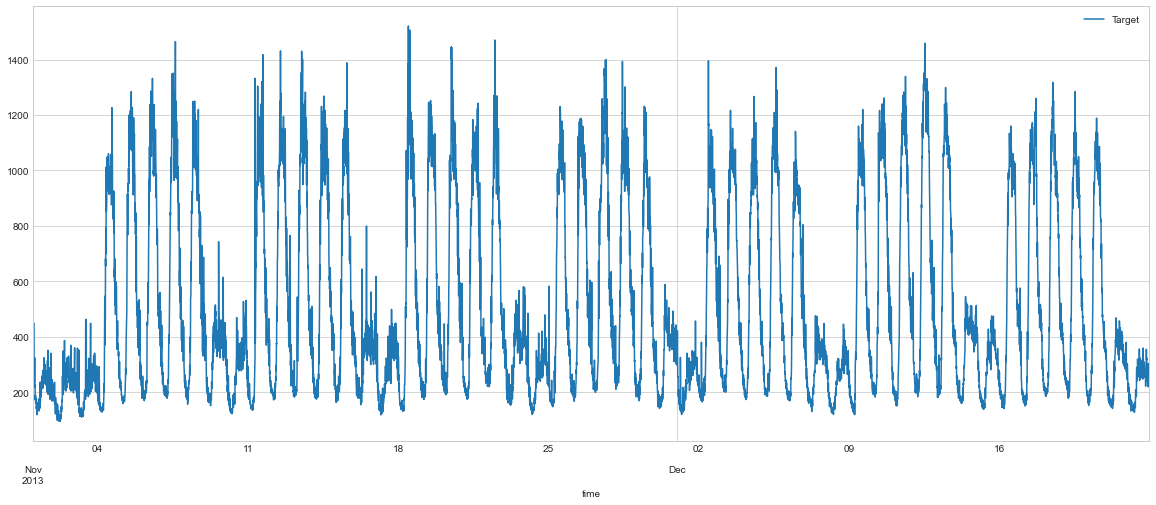

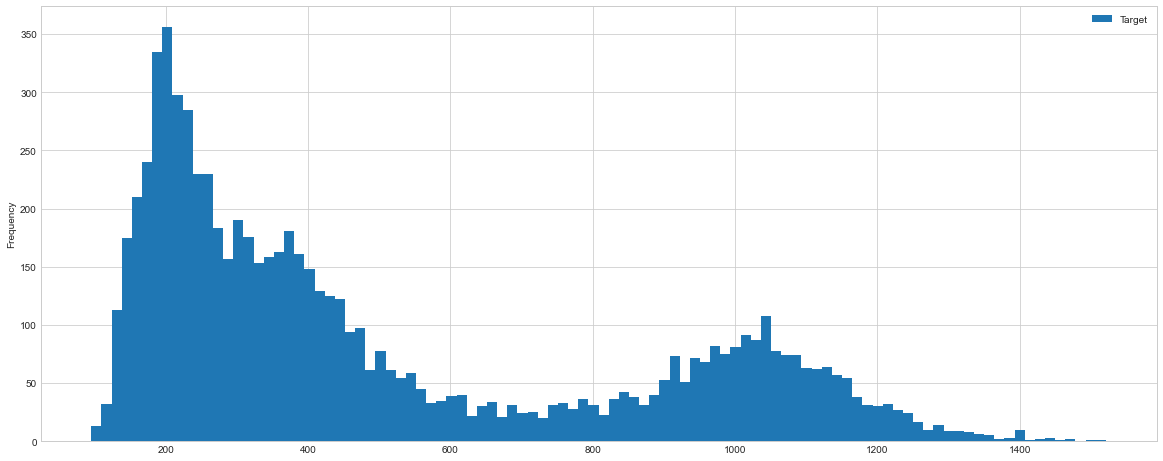

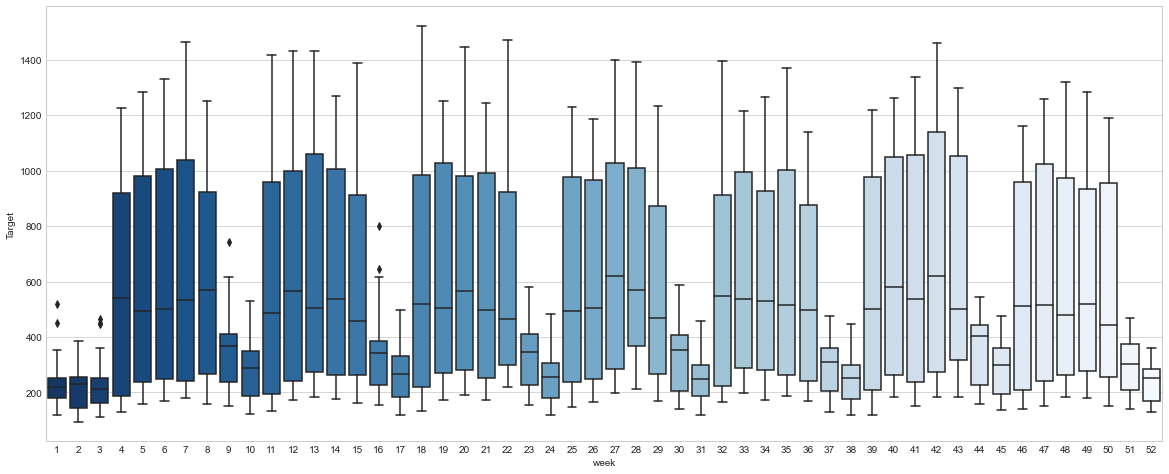

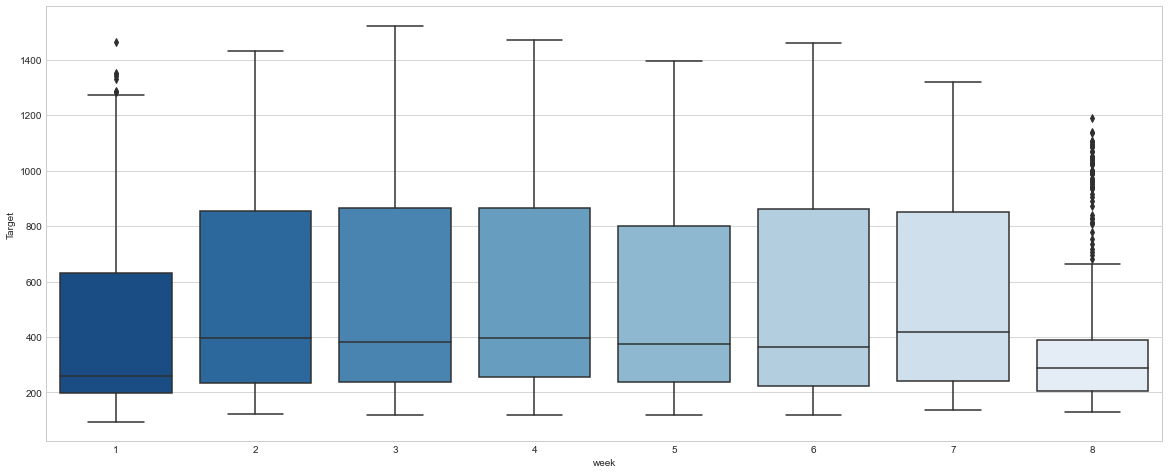

In [13]:
grids_df['Grid(50,56)'].set_index('time').plot(kind='line', figsize=(20,8))
grids_df['Grid(50,56)'].set_index('time').plot(kind='hist', bins=100, figsize=(20,8))
plt.figure(figsize=(20,8))
sns.boxplot(data=grids_df['Grid(50,56)'].assign(week=lambda x: x.index//(144)+1),
            y='Target', x='week', palette='Blues_r')
plt.figure(figsize=(20,8))
sns.boxplot(data=grids_df['Grid(50,56)'].assign(week=lambda x: x.index//(7*144)+1),
            y='Target', x='week', palette='Blues_r');

### Complex Seasonalities
- There are complex seasonalities in the data.
- Let's try daily, weekly decompositions, and analysis the residuals in each one.

### Daily decomposition

##### Additive decomposition

In [9]:
_, _, daily_add_resid = ts_decomposition(df=grids_df['Grid(50,56)'], column='Target', 
                                         title='', model='add', period=144, return_results=True)

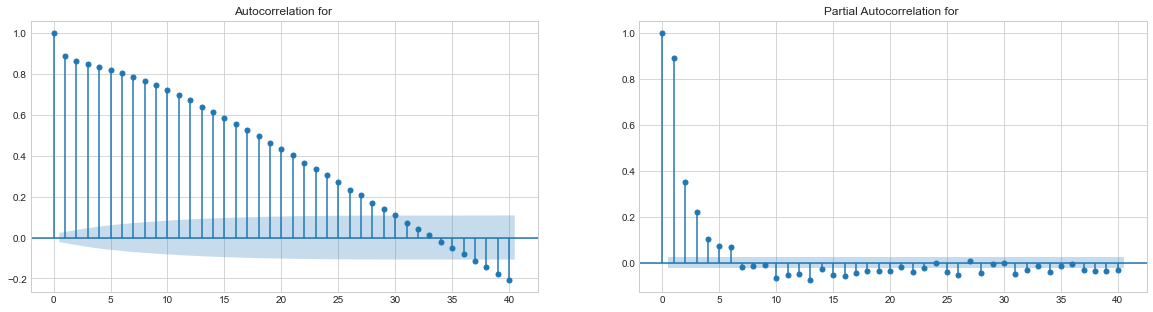

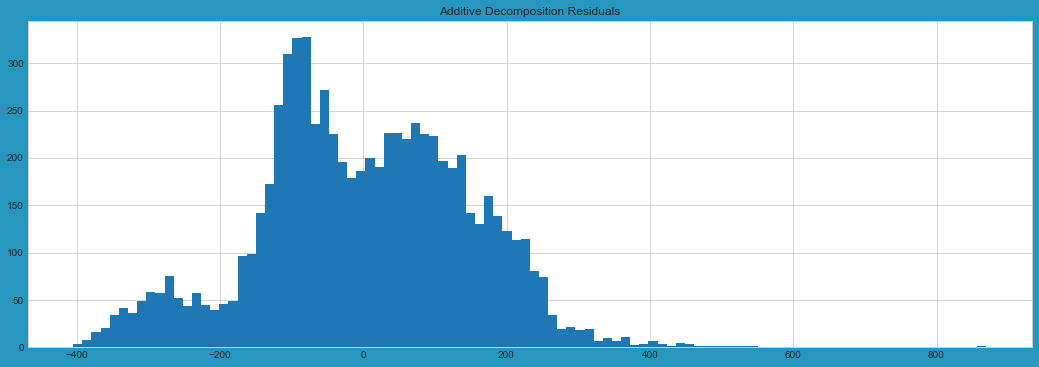

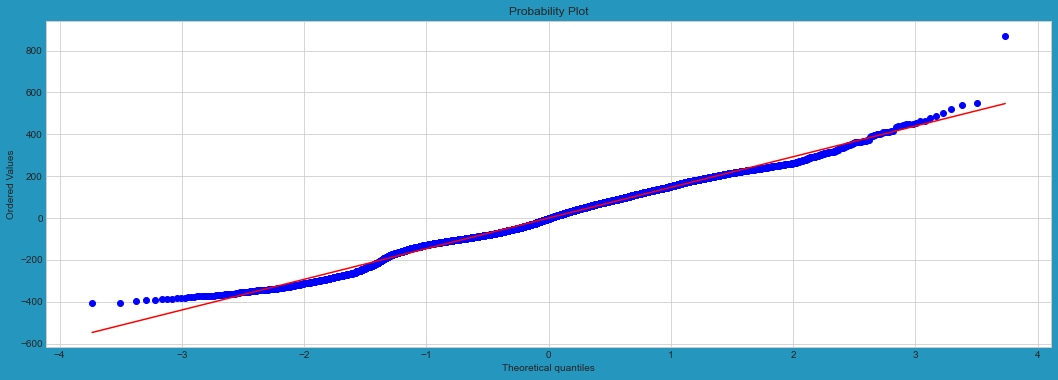

In [10]:
# ACF & PACF Plots
create_acf_pacf(daily_add_resid.dropna(), '')
# Histogram Plot
plt.figure(figsize=(18,6), facecolor='#2596be')
plt.title('Additive Decomposition Residuals')
plt.hist(daily_add_resid.dropna(), bins=100)
# Q-Plot
plt.figure(figsize=(18,6),facecolor='#2596be')
scipy.stats.probplot(daily_add_resid.dropna(), dist='norm', plot=plt);

#### Multiplicative decomposition

In [11]:
_, _, daily_mul_resid = ts_decomposition(df=grids_df['Grid(50,56)'], column='Target', 
                                   title='', model='mul', period=144, return_results=True)

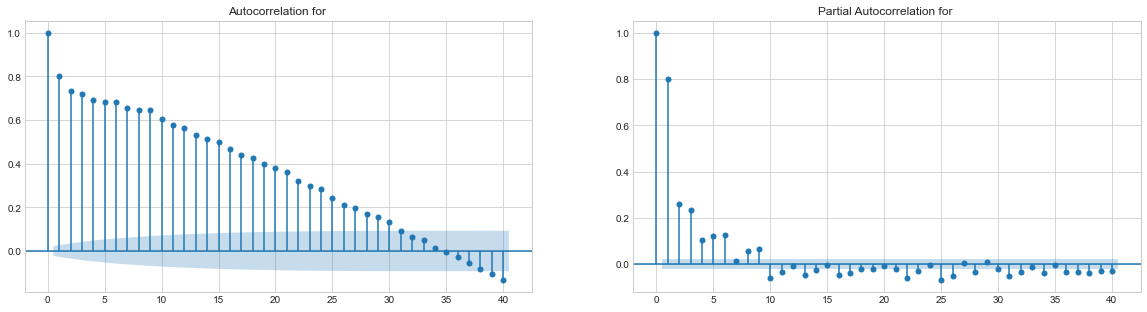

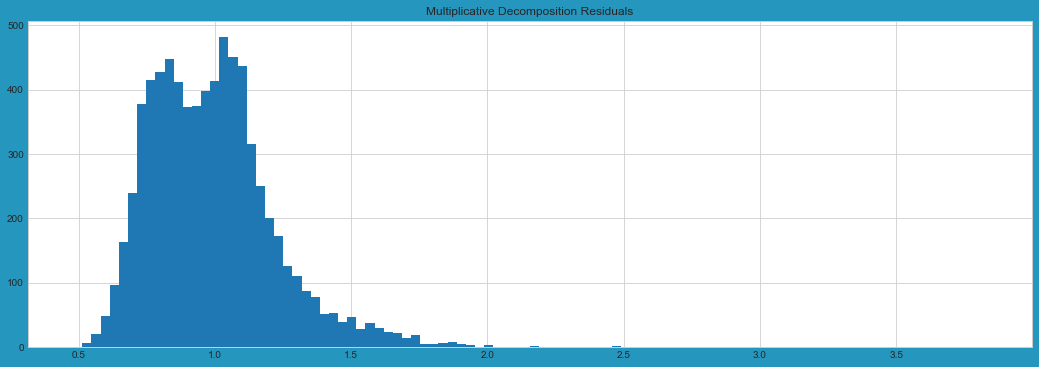

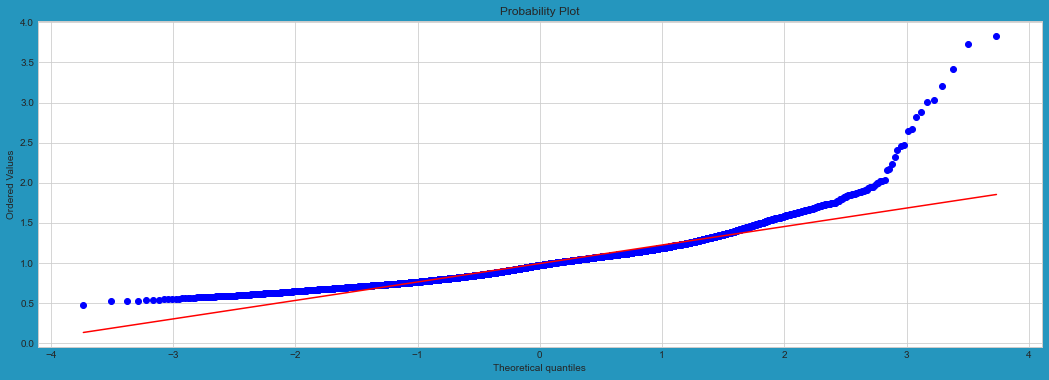

In [12]:
# ACF & PACF Plots
create_acf_pacf(daily_mul_resid.dropna(), '')
# Histogram Plot
plt.figure(figsize=(18,6), facecolor='#2596be')
plt.title('Multiplicative Decomposition Residuals')
plt.hist(daily_mul_resid.dropna(), bins=100)
# Q-Plot
plt.figure(figsize=(18,6),facecolor='#2596be')
scipy.stats.probplot(daily_mul_resid.dropna(), dist='norm', plot=plt);

### Weekly decomposition

##### Additive decomposition

In [13]:
_, _, weekly_add_resid = ts_decomposition(df=grids_df['Grid(50,56)'], column='Target', 
                                          title='', model='add', period=7*144, return_results=True)

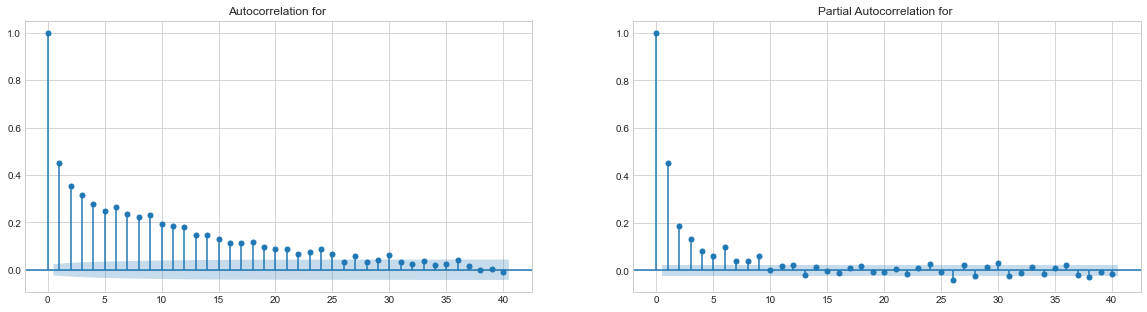

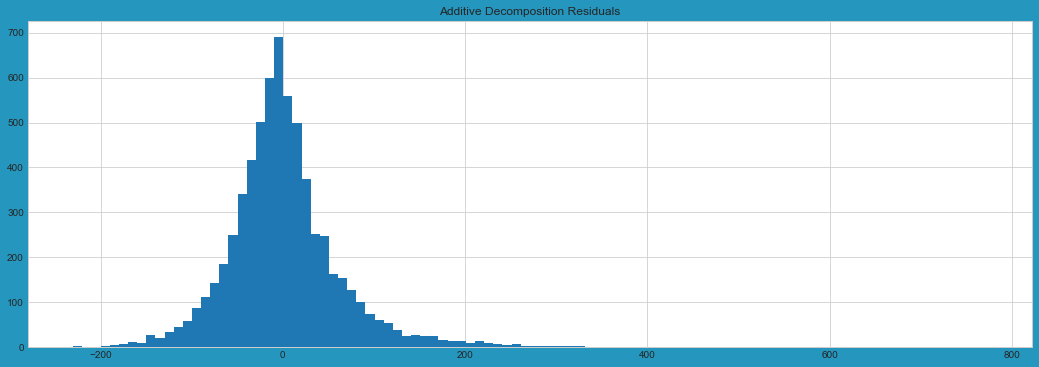

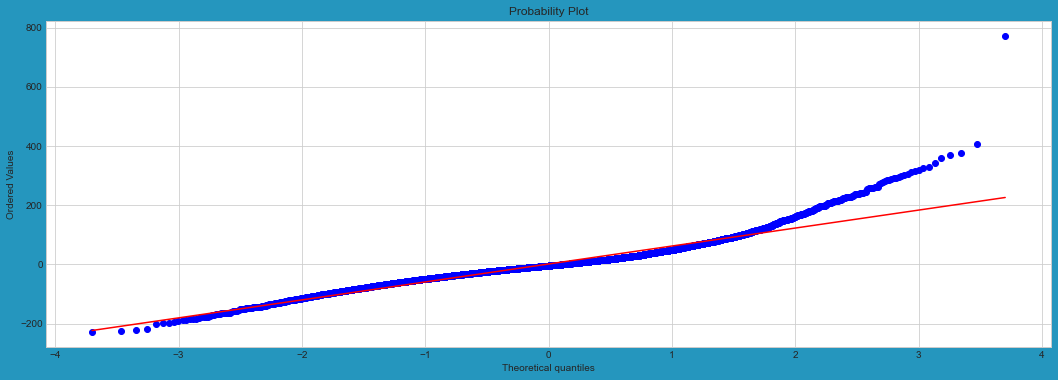

In [14]:
# ACF & PACF Plots
create_acf_pacf(weekly_add_resid.dropna(), '')
# Histogram Plot
plt.figure(figsize=(18,6), facecolor='#2596be')
plt.title('Additive Decomposition Residuals')
plt.hist(weekly_add_resid.dropna(), bins=100)
# Q-Plot
plt.figure(figsize=(18,6),facecolor='#2596be')
scipy.stats.probplot(weekly_add_resid.dropna(), dist='norm', plot=plt);

#### Multiplicative decomposition

In [15]:
_, _, weekly_mul_resid = ts_decomposition(df=grids_df['Grid(50,56)'], column='Target', 
                                          title='', model='mul', period=7*144, return_results=True)

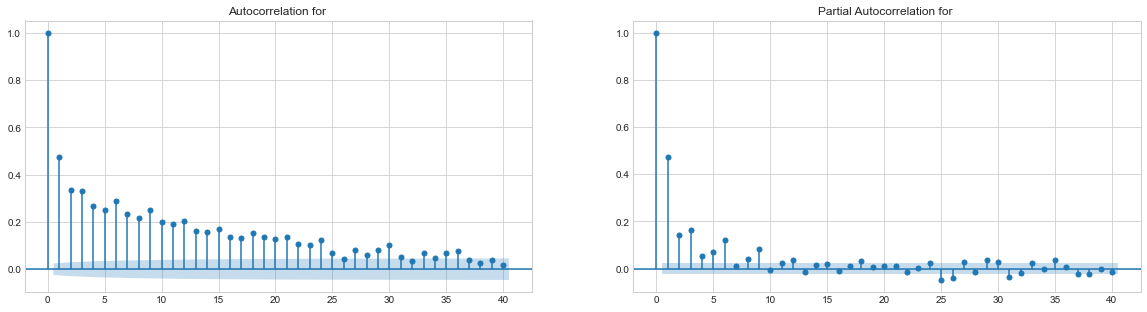

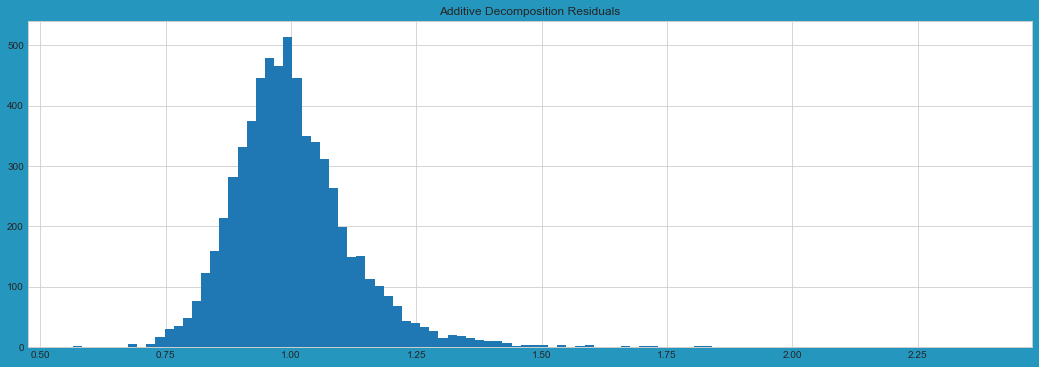

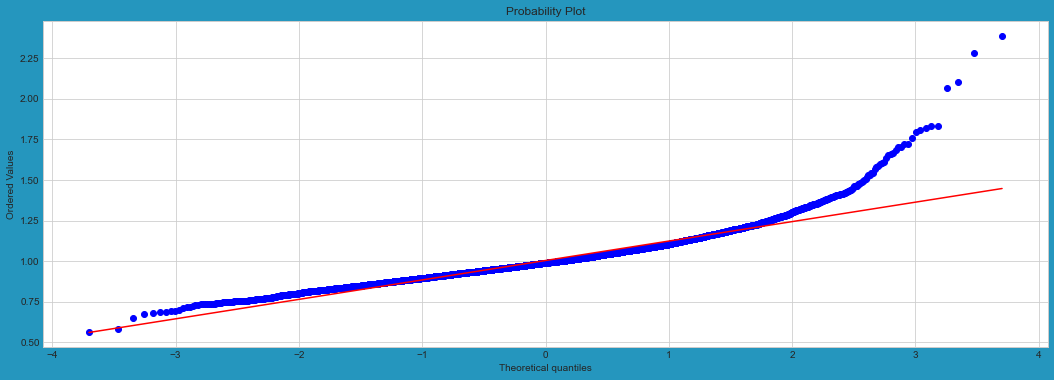

In [16]:
# ACF & PACF Plots
create_acf_pacf(weekly_mul_resid.dropna(), '')
# Histogram Plot
plt.figure(figsize=(18,6), facecolor='#2596be')
plt.title('Additive Decomposition Residuals')
plt.hist(weekly_mul_resid.dropna(), bins=100)
# Q-Plot
plt.figure(figsize=(18,6),facecolor='#2596be')
scipy.stats.probplot(weekly_mul_resid.dropna(), dist='norm', plot=plt);

> - Weekly decomposition's residuals gives:
    - Less correlation appears cleaarly in ACF & PACF plots.
    - Distribution closer to normal distribution.(Mesokurtic)
> - If we look at the residuals of the multiplicative decomposition closely, it has some pattern left over.
> - The additive decomposition, looks quite random which is good. 
> - So ideally, additive decomposition for both daily and weekly should be preferred for this particular grid(TS).

- ### Look at stationarity

Most time-series models assume that the underlying time-series data is **stationary**.  This assumption gives us some nice statistical properties that allows us to use various models for forecasting.

**Stationarity** is a statistical assumption that a time-series has:
*   **Constant mean**
*   **Constant variance**
*   **Autocovariance does not depend on time**

More simply put, if we are using past data to predict future data, we should assume that the data will follow the same general trends and patterns as in the past.  This general statement holds for most training data and modeling tasks.
Sometimes we need to transform the data in order to make it stationary.<br>We can check stationarity using these techniques:

**Testing the stationarity:**
- Rolling mean and standard deviation and look if they are changing over time. 
- Apply Dickey-Fuller test or KPSS test, and see if we can reject the null hypothesis (that the time series is stationary)
- Dickey-Fuller Test:
    - Null Hypothesis: Time Series is stationary. It gives a time-dependent trend.
    - Alternate Hypothesis: Time Series is non-stationary. In another term, the series doesn’t depend on time.
    - ADF or t Statistic < critical values: Accept the null hypothesis. Time series is stationary.
    - ADF or t Statistic > critical values: Failed to reject the null hypothesis. The time series is non-stationary

##### We will use window size equal to one week. (7*144)

===>Results of Dickey-Fuller Test for Target:

Test Statistic                -1.404337e+01
p-value                        3.273293e-26
# Lags Used                    3.600000e+01
Number of Observations Used    7.451000e+03
Critical Value (1%)           -3.431228e+00
Critical Value (5%)           -2.861928e+00
Critical Value (10%)          -2.566977e+00
dtype: float64
Reject Ho ---> Time Series is Stationary


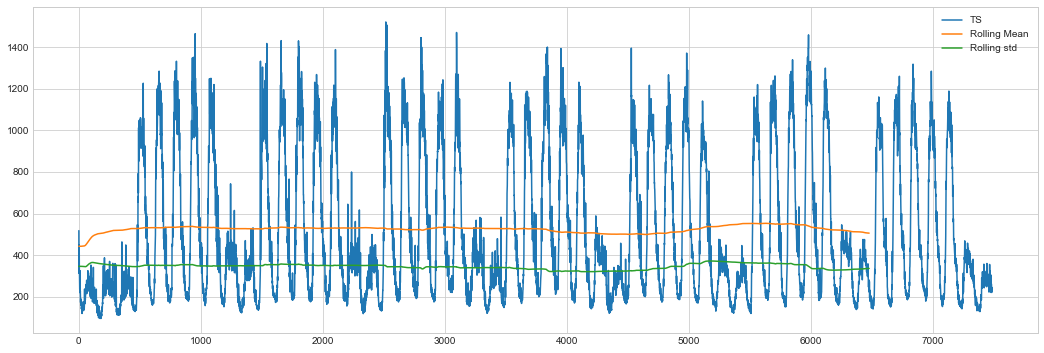

In [17]:
test_stationarity(grids_df['Grid(50,56)'], 'Target', 7*144, title='', ret_values=None)

#### In weekly window:
- Rolling std & mean are `time-invariant` !

### Correlation
- **ACF:** A mathematical representation of the degree of similarity between a given time series and the lagged version of itself over successive time intervals. In other words, instead of calculating the correlation between two different series, we calculate the correlation of the series with an “x” unit lagged version (x∈N) of itself. It describes how well the present value of the series is related with its past values.
<img src='ACF.png'></img><br><br>
<ul>
<li> r(t) = The time series sorted in ascending order
<li> r(t-k) = The same time series as above but shifted by K units (in our case k=3)
<li> r_bar = Average of the original time series</li>
</ul><br>
- **PACF:** Summarizes the relationship between an observation in a TS with an observations at pevious time steps, but with relationships of the intervening obsrvations are removed.<br><br>
So, ACF measures the accumalated affects past lags have on the current value, while PACF measures the direct affect.<br><br>
- The blue area represents Significance

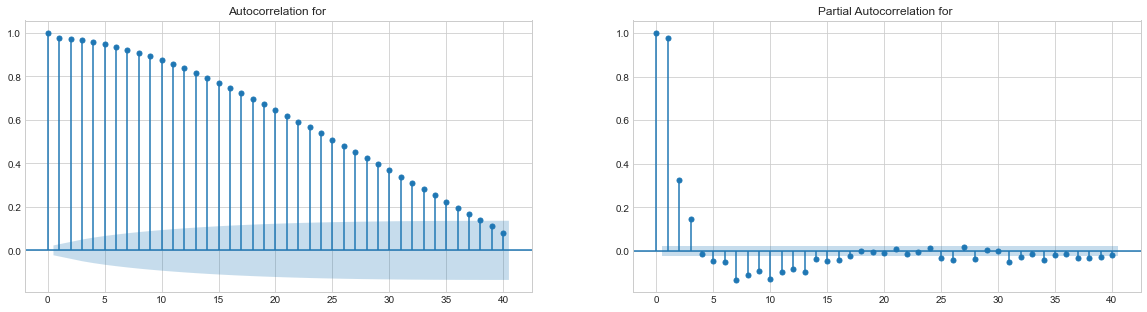

In [28]:
create_acf_pacf(grids_df['Grid(50,56)'].set_index('time'))

#### For ACF:
- Most of spikes are significant.
- All of them are between (1.0 - 0.1).

It shows that the effects are decaying slowly over time, that means that future values of the series are correlated heavily by past values.<br>
The more lags we include, the better the model will fit the data set we feed.

#### For PACF:
- Coefficient in different size.
- Ther're coefficients are neg(-).
- Lags drop away rapidly after 12 lags.
- Ther're coefficients are not significant.(Farest Coefficient)

## Forecasting

#### Sliding Window Forecasting
- Window size = 30 days
    - Forecast one day
    - Forecast two days.
    - Forecast trhee days.
    - Forecast one week.
<img src='sliding_win.jpg'></img>

### 1) Statistical methods

**We will try:**
- ARIMA & STL-ARIMA
- Theta & STL-Theta
- Exponential Smoothing & STL-Exponential Smoothing

In [19]:
window_size = 30
date_iter = (full_data.shape[0]//144) - window_size
day_1 = date_iter - 1

models = ['Theta','STL-Theta','ARIMA','STL-ARIMA','Exponential Smoothing','STL-Exponential Smoothing']

Results = {'Grid(%d,%d)'%(grid[0], grid[1]):
           {'%s'%model : 
            {'Day_1':{'%d'%(i+1):{'results':None, 'errors':None} for i in range(day_1)},
             'Day_2':{'%d'%(i+1):{'results':None, 'errors':None} for i in range(day_1-1)},
             'Day_3':{'%d'%(i+1):{'results':None, 'errors':None} for i in range(day_1-2)},
             'Week' :{'%d'%(i+1):{'results':None, 'errors':None} for i in range(day_1-6)}}
            for model in models}
           for grid in forecast_grids}

with catch_warnings():
    
    filterwarnings("ignore")

    for grid in forecast_grids:
        
        print('='*50)            
        print('================== Grid (%d , %d) ================='%(grid[0], grid[1]))
        print('='*50)
        
        # gathering the data for each grid
        df = grids_df['Grid(%d,%d)'%(grid[0], grid[1])]
        
        # iterating over the last 32 days
        for i in range(0, date_iter-1, 1):
            # sliding window
            print('        ','='*30,'        ')            
            print('==================== Window %d ===================='%(i+1))
            print('        ','='*30,'        \n')
            print('        ============ Training  ============        ')
            
            # divide the data
            data = divide_data(i, df, day_1)
            
            # decomposition
            decomposition = STL(data['Training']['Target'], period=144).fit()
            seasonal, trend, resid = decomposition.seasonal, decomposition.trend, decomposition.resid
            # forecast only (trend + noise)
            data['Training']['Seasonal'] = seasonal
            data['Training']['Trend_Noise'] = trend + resid
            
            Training the models on the current month.(Current window position)
            # Without STL
            print('                ==> Without STL <==         ')
            # 1) Exponintial Smoothing
            exp_model = ExponentialSmoothing(data['Training']['Target'], trend='add',seasonal='add',seasonal_periods=144).fit()
            print('==> Exponential Smoothing is done!\n')
            # 2) ARIMA
            arima_model = ARIMA(order=(20,0,5)).fit(data['Training']['Target'])
            print('==> ARIMA is done!\n')
            # 3) Theta
            theta_model = ThetaModel(data['Training']['Target'], period=144).fit()
            print('==> Theta is done!\n')

            ## With STL
            print('                ==>  With STL   <==         ')

            # 1) STL-Exponintial Smoothing
            args = {'trend':'add', 'seasonal':'add', 'seasonal_periods':144}
            s_exp_model = ExponentialSmoothing(data['Training']['Seasonal'], trend='add',seasonal='add',seasonal_periods=144).fit()
            tn_exp_model = ExponentialSmoothing(data['Training']['Trend_Noise'], trend='add',seasonal='add',seasonal_periods=144).fit()
            print('==> Exponential Smoothing is done!\n')
            # 2) STL-ARIMA
            s_ARIMA_model = ARIMA(order=(20,0,5)).fit(data['Training']['Seasonal'])
            tn_ARIMA_model = ARIMA(order=(20,0,3)).fit(data['Training']['Trend_Noise'])
            print('==> ARIMA is done!\n')
            # 3) STL-Theta
            s_Theta_model = ThetaModel(data['Training']['Seasonal'], period=144).fit()
            tn_Theta_model = ThetaModel(data['Training']['Trend_Noise'], period=144).fit()
            print('==> Theta is done!\n')
            
            # Forecasting 1-Day, 2-Day, 3-Day, and one Week
            print('        ========== Forecasting  ==========        ')
            
            #### 1-Day forecasting
            print('        ','='*30,'        ')            
            print('               ====== 1-Day ======')
            print('        ','='*30,'        \n')
            
            # Exp
            Results = forecasting(exp_model, None, None, i, 'Day_1', 
                                  'Exponential Smoothing', data, Results, 144, grid)
            #STL-Exp
            Results = forecasting(None, s_exp_model, tn_exp_model, i, 'Day_1', 
                                  'STL-Exponential Smoothing', data, Results, 144, grid)
            
            # ARIMA
            Results = forecasting(arima_model, None, None, i, 'Day_1', 
                                  'ARIMA', data, Results, 144, grid)
            #STL-ARIMA
            Results = forecasting(None, s_ARIMA_model, tn_ARIMA_model, i, 'Day_1', 
                                  'STL-ARIMA', data, Results, 144, grid)

            # Theta
            Results = forecasting(theta_model, None, None, i, 'Day_1', 
                                  'Theta', data, Results, 144, grid)
            #STL-Theta
            Results = forecasting(None, s_Theta_model, tn_Theta_model, i, 'Day_1', 
                                  'STL-Theta', data, Results, 144, grid)
            
            #### 2-Day forecasting
            if i < (day_1-1):
                print('        ','='*30,'        ')            
                print('               ====== 2-Day ======')
                print('        ','='*30,'        \n')
                # Exp
                Results = forecasting(exp_model, None, None, i, 'Day_2', 
                                      'Exponential Smoothing', data, Results, 2*144, grid)
                #STL-Exp
                Results = forecasting(None, s_exp_model, tn_exp_model, i, 'Day_2', 
                                      'STL-Exponential Smoothing', data, Results, 2*144, grid)

                # ARIMA
                Results = forecasting(arima_model, None, None, i, 'Day_2', 
                                      'ARIMA', data, Results, 2*144, grid)
                #STL-ARIMA
                Results = forecasting(None, s_ARIMA_model, tn_ARIMA_model, i, 'Day_2', 
                                      'STL-ARIMA', data, Results, 2*144, grid)

                # Theta
                Results = forecasting(theta_model, None, None, i, 'Day_2', 
                                      'Theta', data, Results, 2*144, grid)
                #STL-Theta
                Results = forecasting(None, s_Theta_model, tn_Theta_model, i, 'Day_2', 
                                      'STL-Theta', data, Results, 2*144, grid)

            #### 3-Day forecasting
            if i < (day_1-2):    
                print('        ','='*30,'        ')            
                print('               ====== 3-Day ======')
                print('        ','='*30,'        \n')
            
                # Exp
                Results = forecasting(exp_model, None, None, i, 'Day_3', 
                                      'Exponential Smoothing', data, Results, 3*144, grid)
                #STL-Exp
                Results = forecasting(None, s_exp_model, tn_exp_model, i, 'Day_3', 
                                      'STL-Exponential Smoothing', data, Results,3*144, grid)

                # ARIMA
                Results = forecasting(arima_model, None, None, i, 'Day_3', 
                                      'ARIMA', data, Results,3*144, grid)
                #STL-ARIMA
                Results = forecasting(None, s_ARIMA_model, tn_ARIMA_model, i, 'Day_3', 
                                      'STL-ARIMA', data, Results,3*144, grid)

                # Theta
                Results = forecasting(theta_model, None, None, i, 'Day_3', 
                                      'Theta', data, Results,3*144, grid)
                #STL-Theta
                Results = forecasting(None, s_Theta_model, tn_Theta_model, i, 'Day_3', 
                                      'STL-Theta', data, Results,3*144, grid)
            
            #### week forecasting
            if i < (day_1-6):
                print('        ','='*30,'        ')  
                print('               ====== Week  ======')
                print('        ','='*30,'        \n')
                # Exp
                Results = forecasting(exp_model, None, None, i, 'Week', 
                                      'Exponential Smoothing', data, Results, 7*144, grid)
                #STL-Exp
                Results = forecasting(None, s_exp_model, tn_exp_model, i, 'Week', 
                                      'STL-Exponential Smoothing', data, Results, 7*144, grid)

                # ARIMA
                Results = forecasting(arima_model, None, None, i, 'Week', 
                                      'ARIMA', data, Results, 7*144, grid)
                #STL-ARIMA
                Results = forecasting(None, s_ARIMA_model, tn_ARIMA_model, i, 'Week', 
                                      'STL-ARIMA', data, Results, 7*144, grid)

                # Theta
                Results = forecasting(theta_model, None, None, i, 'Week', 
                                      'Theta', data, Results, 7*144, grid)
                #STL-Theta
                Results = forecasting(None, s_Theta_model, tn_Theta_model, i, 'Week', 
                                      'STL-Theta', data, Results, 7*144, grid)

================== Grid (50 , 56) =================
==================== Window 1 ====================
        ============ Training  ============        
               ==> Without STL <==
               
          Exponential Smoothing is done!          
                  ARIMA is done!                  
                 Theta is done!
                  
               ==>  With STL   <==
               
          Exponential Smoothing is done!          
                  ARIMA is done!                  
                 Theta is done!
                  
        ========== Forecasting  ==========        
               ====== 1-Day ======                

               ====== 2-Day ======                

               ====== 3-Day ======                

               ====== Week  ======                

==================== Window 2 ====================
        ============ Training  ============        
               ==> Without STL <==
               
          Exponential Sm

               ====== 3-Day ======                

               ====== Week  ======                

==================== Window 2 ====================
        ============ Training  ============        
               ==> Without STL <==
               
          Exponential Smoothing is done!          
                  ARIMA is done!                  
                 Theta is done!
                  
               ==>  With STL   <==
               
          Exponential Smoothing is done!          
                  ARIMA is done!                  
                 Theta is done!
                  
        ========== Forecasting  ==========        
               ====== 1-Day ======                

               ====== 2-Day ======                

               ====== 3-Day ======                

               ====== Week  ======                

==================== Window 3 ====================
        ============ Training  ============        
               ==> With


==================== Window 3 ====================
        ============ Training  ============        
               ==> Without STL <==
               
          Exponential Smoothing is done!          
                  ARIMA is done!                  
                 Theta is done!
                  
               ==>  With STL   <==
               
          Exponential Smoothing is done!          
                  ARIMA is done!                  
                 Theta is done!
                  
        ========== Forecasting  ==========        
               ====== 1-Day ======                

               ====== 2-Day ======                

               ====== 3-Day ======                

               ====== Week  ======                

==================== Window 4 ====================
        ============ Training  ============        
               ==> Without STL <==
               
          Exponential Smoothing is done!          
                  ARIMA 

               ====== Week  ======                

==================== Window 8 ====================
        ============ Training  ============        
               ==> Without STL <==
               
          Exponential Smoothing is done!          
                  ARIMA is done!                  
                 Theta is done!
                  
               ==>  With STL   <==
               
          Exponential Smoothing is done!          
                  ARIMA is done!                  
                 Theta is done!
                  
        ========== Forecasting  ==========        
               ====== 1-Day ======                

               ====== 2-Day ======                

               ====== 3-Day ======                

               ====== Week  ======                

==================== Window 9 ====================
        ============ Training  ============        
               ==> Without STL <==
               
          Exponential Sm

          Exponential Smoothing is done!          
                  ARIMA is done!                  
                 Theta is done!
                  
               ==>  With STL   <==
               
          Exponential Smoothing is done!          
                  ARIMA is done!                  
                 Theta is done!
                  
        ========== Forecasting  ==========        
               ====== 1-Day ======                

               ====== 2-Day ======                

               ====== 3-Day ======                

               ====== Week  ======                

==================== Window 12 ====================
        ============ Training  ============        
               ==> Without STL <==
               
          Exponential Smoothing is done!          
                  ARIMA is done!                  
                 Theta is done!
                  
               ==>  With STL   <==
               
          Exponential Smo

##### Save the results

In [6]:
# a_file = open("STAT_Results.pkl", "wb")
# pickle.dump(STAT_Results, a_file)
# a_file.close()
file = open("STAT_Results.pkl", "rb")
STAT_Results = pickle.load(file)
# print(Results)
file.close()

#### <h3 align="center"> Results Structure</h3>
<img src="Dic_Str.png">

### Errors Visualization

###### Errors Table

In [7]:
grids_stat_errors = dict_to_dataframe(STAT_Results, forecast_grids)

In [8]:
pd.set_option('display.float_format','{:0.6}'.format)
grids_stat_errors['Grid(50,56)'].sort_values(by=('Week','MAPE'), ascending=True)

1-Day             2-Day             3-Day  \
                              MAPE    NRMSE     MAPE    NRMSE     MAPE   
Theta                     0.342038 0.487364 0.339116 0.450372 0.351772   
Stl-Theta                 0.368856 0.491655 0.356783 0.431656 0.364459   
Stl-Arima                  0.59981 0.571386  0.69545  0.61662 0.734687   
Arima                      0.67156 0.626114 0.734972 0.626349 0.762703   
Stl-Exponential Smoothing 0.604445 0.741614 0.590518  0.63955 0.608565   
Exponential Smoothing     0.598316 0.777457 0.722893 0.806086 0.922574   

                                       Week           
                             NRMSE     MAPE    NRMSE  
Theta                     0.444825 0.357986 0.441542  
Stl-Theta                  0.41623 0.387097 0.418268  
Stl-Arima                 0.627482 0.789869 0.647569  
Arima                     0.630247 0.815808 0.647712  
Stl-Exponential Smoothing 0.612984   0.9464 0.822149  
Exponential Smoothing     0.929824  1.06467  0.89973

###### Box plot for Grid's Errors

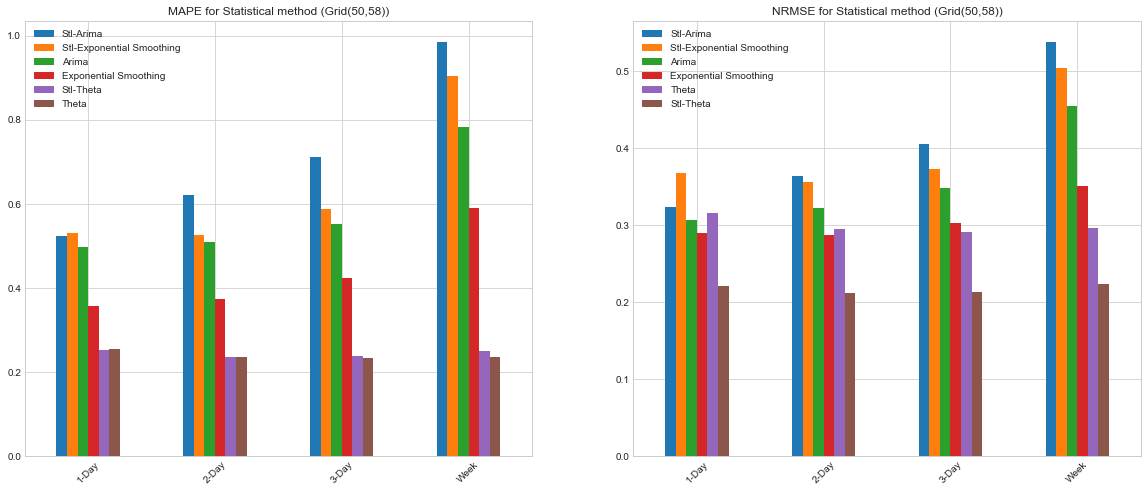

In [15]:
days = set(grids_stat_errors['Grid(50,58)'].columns.get_level_values(0))
figure, axes = plt.subplots(1, 2)
(
    pd.DataFrame([grids_stat_errors['Grid(50,58)'][d]['MAPE'] for d in days], index=days).T
    .sort_values('Week', ascending=False).T
    .plot(kind='bar',
          grid=True,
          ax=axes[0],
          rot='45',
          layout=(4, 3),
          title='MAPE for Statistical method (Grid(50,58))',
          figsize=(20,8))
)
(
    pd.DataFrame([grids_stat_errors['Grid(50,58)'][d]['NRMSE'] for d in days], index=days).T
    .sort_values('Week', ascending=False).T
    .plot(kind='bar',
          grid=True,
          ax=axes[1],
          rot='45',
          layout=(4, 3),
          title='NRMSE for Statistical method (Grid(50,58))',
          figsize=(20,8))
);

#### Box Plot

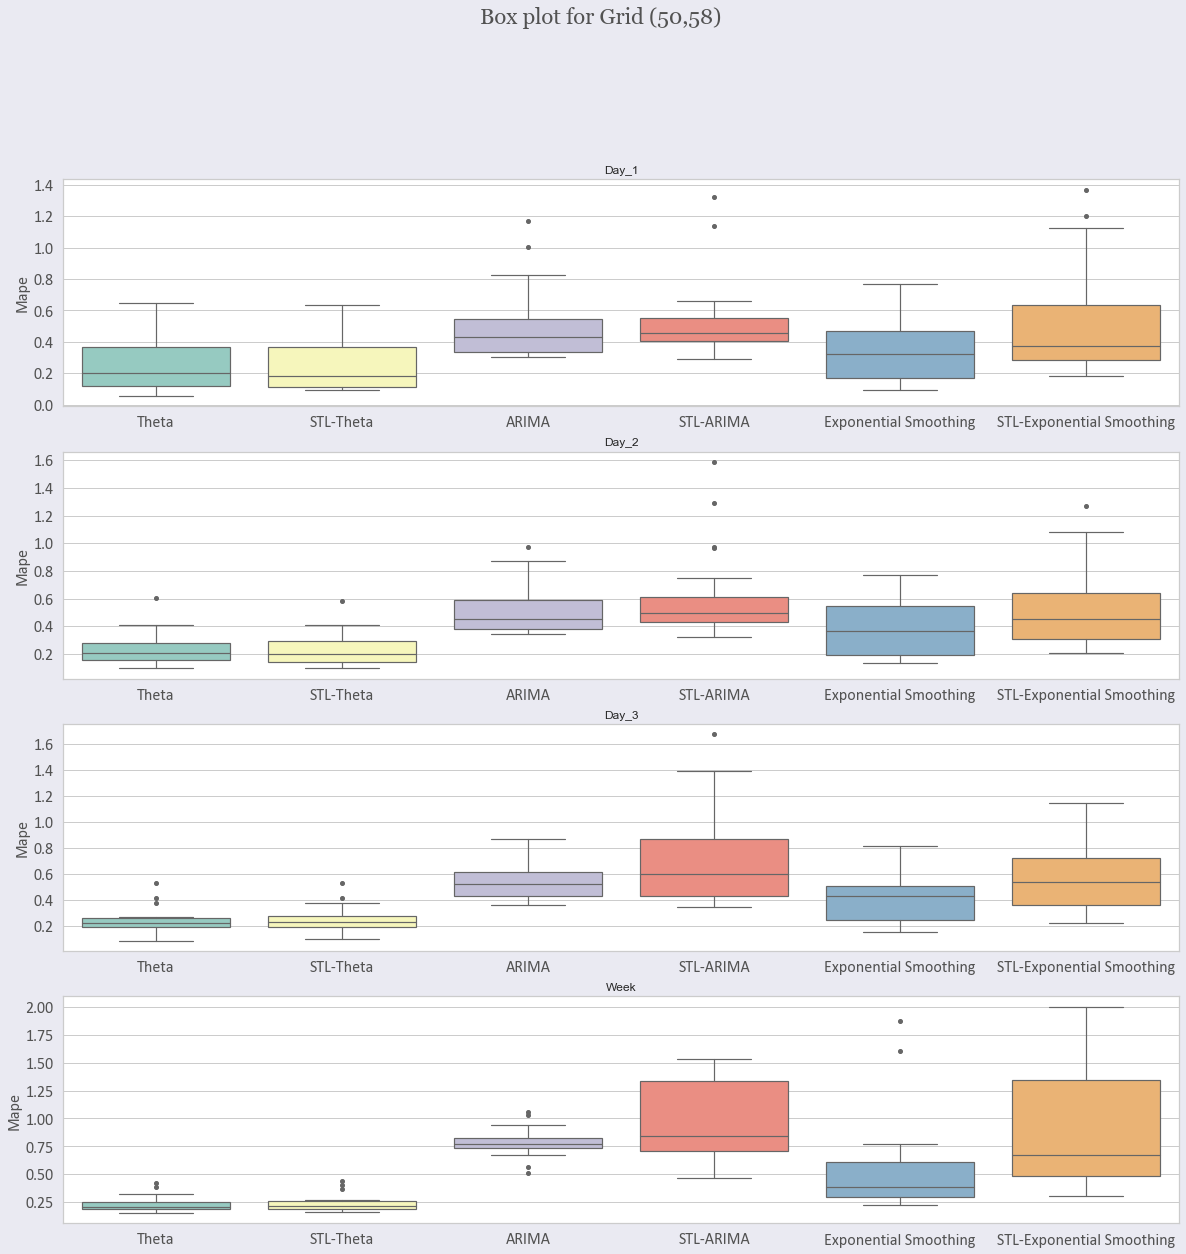

In [16]:
errors_box(STAT_Results, (50,58), 'mape')

======================================== Grid(50,56) ========================================
                                    =====  Week  ======                                    


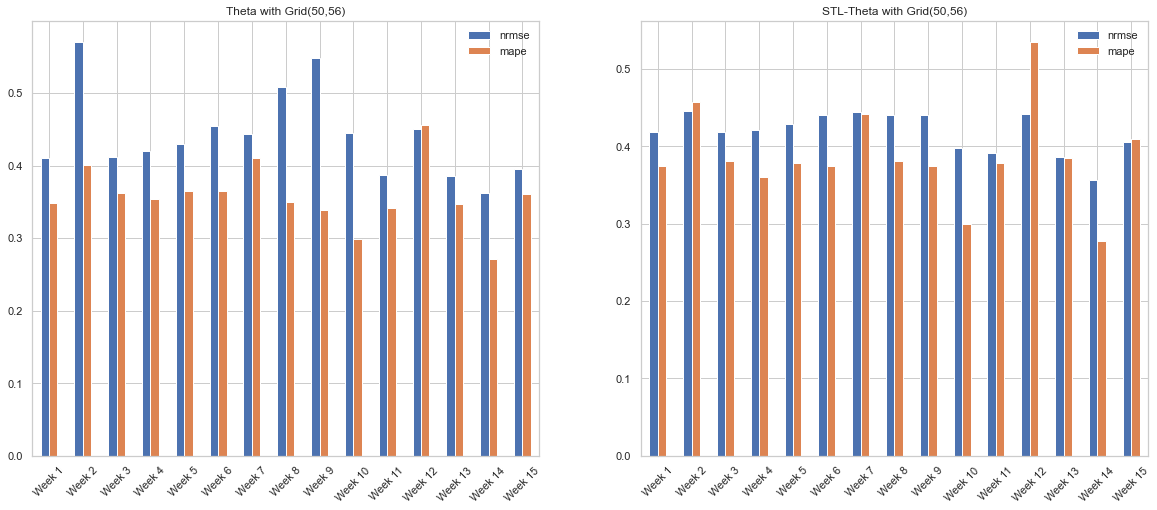

======================================== Grid(50,56) ========================================
                                    =====  Week  ======                                    


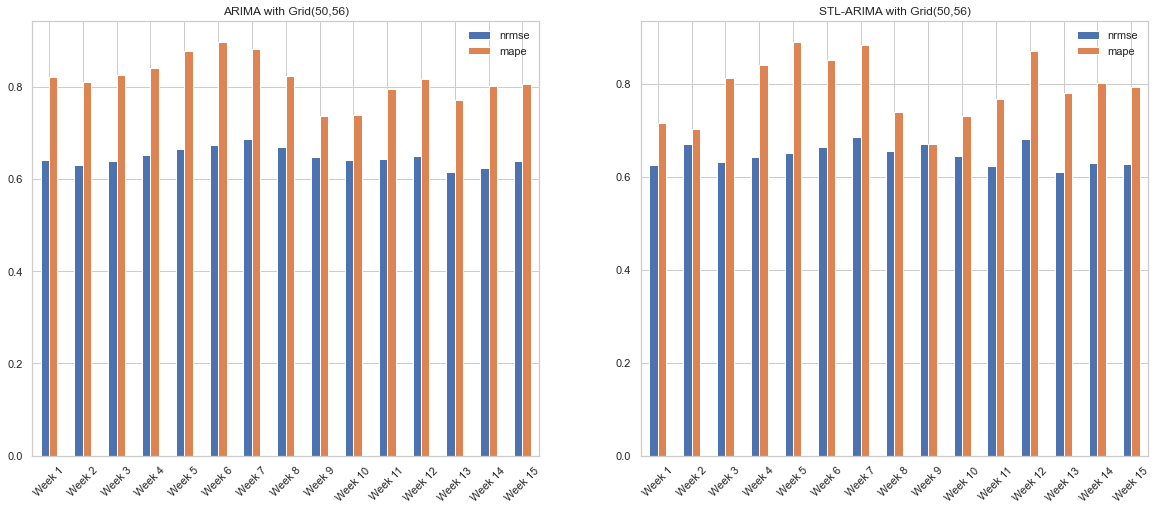

======================================== Grid(50,56) ========================================
                                    =====  Week  ======                                    


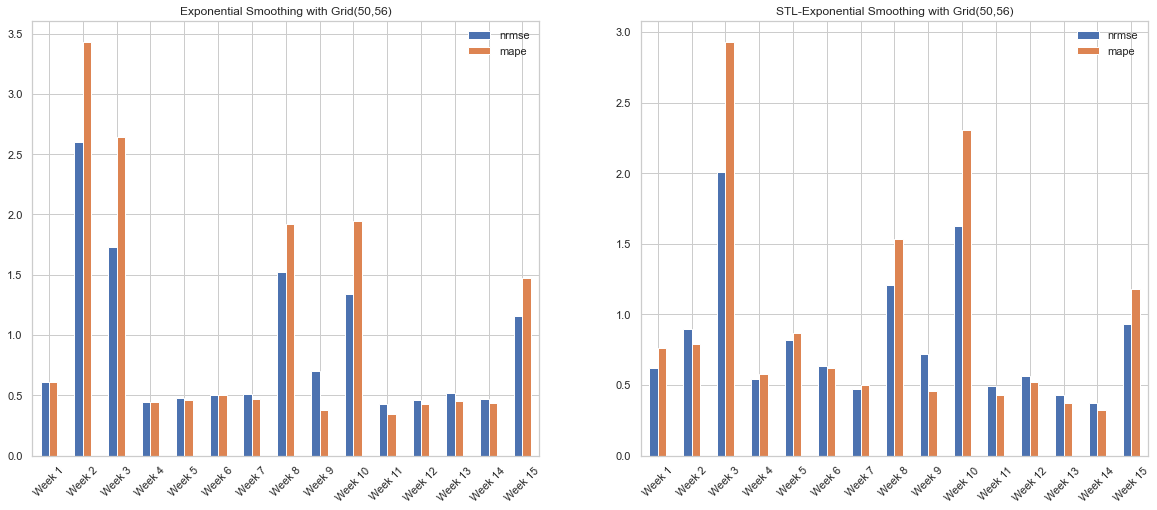

In [25]:
plot_errors(STAT_Results, 'Weeks', ['Theta','STL-Theta'], ['Grid(50,56)'])
plot_errors(STAT_Results, 'Weeks', ['ARIMA','STL-ARIMA'], ['Grid(50,56)'])
plot_errors(STAT_Results, 'Weeks', ['Exponential Smoothing','STL-Exponential Smoothing'], ['Grid(50,56)'])

>#### We can do the same for 1-Day, 2-Days, 3-Days forecasting for each grid.

#### I think the complex seasonality of the data affects the performance of statistical methods heavily.
#### We can avoid this affects using :
 - Prophet.
 - Dynamic harmonic regression with multiple seasonal periods.
 - TBATS : Trigonometric seasonality, Box-Cox transformation, ARMA errors, Trend and Seasonal.

### Machine Learninig algorithms

Multi-step-ahead forecasts can be produced recursively by:
- `Recursivly` : 
   - Make a prediction for one time step.
   - Take the prediction, and feeding it into the model as an input in order to predict the subsequent time step.
   - This process is repeated until the desired number of steps have been forecasted.
   
   
- `Directly` : 
    - Using a specific model for each horizon. 


- So, I think using `Recursive` method gives higher errors, because we are forecasting some values based on another forecasted values which also has some errors !

- Also, using `Direct` method will have less variance ,but I think it will be more biased, also less of the training data can be used for each model.

So, we can work `Recursivly`!

**We will try:**
- SVR & STL-SVR
- Lasso & STL-Lasso
- ElasticNet & STL-ElasticNet
- KNeighborsRegressor & STL-KNeighborsRegressor
- LinearRegression & STL-LinearRegression
**
<a href="https://arxiv.org/abs/1909.07872">Sktime</a>

In [33]:
window_size = 30
date_iter = (full_data.shape[0]//144) - window_size
day_1 = date_iter - 1

models = ['knn','stl-knn',
          'svr','stl-svr',
          'lasso','stl-lasso',
          'elasticnet','stl-elasticnet',
          'linearregression','stl-linearregression']

ML_Results = {'Grid(%d,%d)'%(grid[0], grid[1]):
              {'%s'%model : 
               {'Day_1':{'%d'%(i+1):{'results':None, 'errors':None} for i in range(day_1)},
                'Day_2':{'%d'%(i+1):{'results':None, 'errors':None} for i in range(day_1-1)},
                'Day_3':{'%d'%(i+1):{'results':None, 'errors':None} for i in range(day_1-2)},
                'Week' :{'%d'%(i+1):{'results':None, 'errors':None} for i in range(day_1-6)}}
               for model in models}
              for grid in forecast_grids}



with catch_warnings():
    
    filterwarnings("ignore")
    
    for grid in forecast_grids:
        
        print('='*50)            
        print('================== Grid (%d , %d) ================'%(grid[0], grid[1]))
        print('='*50)
        
        # gathering the data for each grid
        df = grids_df['Grid(%d,%d)'%(grid[0], grid[1])]
        
        # iterating over the last 32 days
        for i in range(0, date_iter-1, 1):
            # sliding window
            print('        ','='*30,'        ')            
            print('==================== Window %d ===================='%(i+1))
            print('        ','='*30,'        \n')
#             print('        ============ Training  ============        ')
            
            # divide the data
            data = divide_data(i, df, day_1)
            
            #### 1-Day forecasting
            # KNN
            ML_Results = ml_forecast(i, data, 'KNN', {'n_neighbors':15}, 'Day_1', ML_Results, grid)
            #STL-KNN
            ML_Results = ml_forecast(i, data, 'stl-KNN', {'n_neighbors':15}, 'Day_1', ML_Results, grid)
            # SVR
            ML_Results = ml_forecast(i, data, 'SVR', {}, 'Day_1', ML_Results, grid)
            #STL-SVR
            ML_Results = ml_forecast(i, data, 'stl-SVR', {}, 'Day_1', ML_Results, grid)
            # Lasso
            ML_Results = ml_forecast(i, data, 'Lasso', {'alpha':0.003}, 'Day_1', ML_Results, grid)
            #STL-Lasso
            ML_Results = ml_forecast(i, data, 'stl-Lasso', {'alpha':0.003}, 'Day_1', ML_Results, grid)
            # ElasticNet
            ML_Results = ml_forecast(i, data, 'ElasticNet', {'alpha':0.003}, 'Day_1', ML_Results, grid)
            #STL-ElasticNet
            ML_Results = ml_forecast(i, data, 'stl-ElasticNet', {'alpha':0.003}, 'Day_1', ML_Results, grid)
            # LinearRegression
            ML_Results = ml_forecast(i, data, 'LinearRegression', {}, 'Day_1', ML_Results, grid)
            #STL-LinearRegression
            ML_Results = ml_forecast(i, data, 'stl-LinearRegression', {}, 'Day_1', ML_Results, grid)
            print('        ','='*30,'        ')            
            print('               ====== 1-Day ======')
            print('        ','='*30,'        \n')
            
            #### 2-Day forecasting
            if i < (day_1-1):
                # KNN
                ML_Results = ml_forecast(i, data, 'KNN', {'n_neighbors':15}, 'Day_2', ML_Results, grid)
                #STL-KNN
                ML_Results = ml_forecast(i, data, 'stl-KNN', {'n_neighbors':15}, 'Day_2', ML_Results, grid)
                # SVR
                ML_Results = ml_forecast(i, data, 'SVR', {}, 'Day_2', ML_Results, grid)
                #STL-SVR
                ML_Results = ml_forecast(i, data, 'stl-SVR', {}, 'Day_2', ML_Results, grid)
                # Lasso
                ML_Results = ml_forecast(i, data, 'Lasso', {'alpha':0.003}, 'Day_2', ML_Results, grid)
                #STL-Lasso
                ML_Results = ml_forecast(i, data, 'stl-Lasso', {'alpha':0.003}, 'Day_2', ML_Results, grid)
                # ElasticNet
                ML_Results = ml_forecast(i, data, 'ElasticNet', {'alpha':0.003}, 'Day_2', ML_Results, grid)
                #STL-ElasticNet
                ML_Results = ml_forecast(i, data, 'stl-ElasticNet', {'alpha':0.003}, 'Day_2', ML_Results, grid)
                # LinearRegression
                ML_Results = ml_forecast(i, data, 'LinearRegression', {}, 'Day_2', ML_Results, grid)
                #STL-LinearRegression
                ML_Results = ml_forecast(i, data, 'stl-LinearRegression', {}, 'Day_2', ML_Results, grid)
                print('        ','='*30,'        ')            
                print('               ====== 2-Day ======')
                print('        ','='*30,'        \n')
                
            #### 3-Day forecasting
            if i < (day_1-2):    
                # KNN
                ML_Results = ml_forecast(i, data, 'KNN', {'n_neighbors':15}, 'Day_3', ML_Results, grid)
                #STL-KNN
                ML_Results = ml_forecast(i, data, 'stl-KNN', {'n_neighbors':15}, 'Day_3', ML_Results, grid)
                # SVR
                ML_Results = ml_forecast(i, data, 'SVR', {}, 'Day_3', ML_Results, grid)
                #STL-SVR
                ML_Results = ml_forecast(i, data, 'stl-SVR', {}, 'Day_3', ML_Results, grid)
                # Lasso
                ML_Results = ml_forecast(i, data, 'Lasso', {'alpha':0.003}, 'Day_3', ML_Results, grid)
                #STL-Lasso
                ML_Results = ml_forecast(i, data, 'stl-Lasso', {'alpha':0.003}, 'Day_3', ML_Results, grid)
                # ElasticNet
                ML_Results = ml_forecast(i, data, 'ElasticNet', {'alpha':0.003}, 'Day_3', ML_Results, grid)
                #STL-ElasticNet
                ML_Results = ml_forecast(i, data, 'stl-ElasticNet', {'alpha':0.003}, 'Day_3', ML_Results, grid)
                # LinearRegression
                ML_Results = ml_forecast(i, data, 'LinearRegression', {}, 'Day_3', ML_Results, grid)
                #STL-LinearRegression
                ML_Results = ml_forecast(i, data, 'stl-LinearRegression', {}, 'Day_3', ML_Results, grid)
                print('        ','='*30,'        ')            
                print('               ====== 3-Day ======')
                print('        ','='*30,'        \n')
                
            #### week forecasting
            if i < (day_1-6):
                # KNN
                ML_Results = ml_forecast(i, data, 'KNN', {'n_neighbors':15}, 'Week', ML_Results, grid)
                #STL-KNN
                ML_Results = ml_forecast(i, data, 'stl-KNN', {'n_neighbors':15}, 'Week', ML_Results, grid)
                # SVR
                ML_Results = ml_forecast(i, data, 'SVR', {}, 'Week', ML_Results, grid)
                #STL-SVR
                ML_Results = ml_forecast(i, data, 'stl-SVR', {}, 'Week', ML_Results, grid)
                # Lasso
                ML_Results = ml_forecast(i, data, 'Lasso', {'alpha':0.003}, 'Week', ML_Results, grid)
                #STL-Lasso
                ML_Results = ml_forecast(i, data, 'stl-Lasso', {'alpha':0.003}, 'Week', ML_Results, grid)
                # ElasticNet
                ML_Results = ml_forecast(i, data, 'ElasticNet', {'alpha':0.003}, 'Week', ML_Results, grid)
                #STL-ElasticNet
                ML_Results = ml_forecast(i, data, 'stl-ElasticNet', {'alpha':0.003}, 'Week', ML_Results, grid)
                # LinearRegression
                ML_Results = ml_forecast(i, data, 'LinearRegression', {}, 'Week', ML_Results, grid)
                #STL-LinearRegression
                ML_Results = ml_forecast(i, data, 'stl-LinearRegression', {}, 'Week', ML_Results, grid)
                print('        ','='*30,'        ')  
                print('               ====== Week  ======')
                print('        ','='*30,'        \n')

================== Grid (50 , 56) ================
==================== Window 1 ====================

               ====== 1-Day ======

               ====== 2-Day ======

               ====== 3-Day ======

               ====== Week  ======

==================== Window 2 ====================

               ====== 1-Day ======

               ====== 2-Day ======

               ====== 3-Day ======

               ====== Week  ======

==================== Window 3 ====================

               ====== 1-Day ======

               ====== 2-Day ======

               ====== 3-Day ======

               ====== Week  ======

==================== Window 4 ====================

               ====== 1-Day ======

               ====== 2-Day ======

               ====== 3-Day ======

               ====== Week  ======

==================== Window 5 ====================

               ====== 1-Day ======

               ====== 2-Day ======

               ====== 3-Day ======

     


               ====== 2-Day ======

               ====== 3-Day ======

==================== Window 18 ====================

               ====== 1-Day ======

               ====== 2-Day ======

               ====== 3-Day ======

==================== Window 19 ====================

               ====== 1-Day ======

               ====== 2-Day ======

               ====== 3-Day ======

==================== Window 20 ====================

               ====== 1-Day ======

               ====== 2-Day ======

==================== Window 21 ====================

               ====== 1-Day ======

================== Grid (50 , 58) ================
==================== Window 1 ====================

               ====== 1-Day ======

               ====== 2-Day ======

               ====== 3-Day ======

               ====== Week  ======

==================== Window 2 ====================

               ====== 1-Day ======

               ====== 2-Day ======

               =====


               ====== 1-Day ======

================== Grid (51 , 57) ================
==================== Window 1 ====================

               ====== 1-Day ======

               ====== 2-Day ======

               ====== 3-Day ======

               ====== Week  ======

==================== Window 2 ====================

               ====== 1-Day ======

               ====== 2-Day ======

               ====== 3-Day ======

               ====== Week  ======

==================== Window 3 ====================

               ====== 1-Day ======

               ====== 2-Day ======

               ====== 3-Day ======

               ====== Week  ======

==================== Window 4 ====================

               ====== 1-Day ======

               ====== 2-Day ======

               ====== 3-Day ======

               ====== Week  ======

==================== Window 5 ====================

               ====== 1-Day ======

               ====== 2-Day ======

    


               ====== 2-Day ======

               ====== 3-Day ======

==================== Window 17 ====================

               ====== 1-Day ======

               ====== 2-Day ======

               ====== 3-Day ======

==================== Window 18 ====================

               ====== 1-Day ======

               ====== 2-Day ======

               ====== 3-Day ======

==================== Window 19 ====================

               ====== 1-Day ======

               ====== 2-Day ======

               ====== 3-Day ======

==================== Window 20 ====================

               ====== 1-Day ======

               ====== 2-Day ======

==================== Window 21 ====================

               ====== 1-Day ======

================== Grid (52 , 56) ================
==================== Window 1 ====================

               ====== 1-Day ======

               ====== 2-Day ======

               ====== 3-Day ======

               ====

               ====== 1-Day ======

               ====== 2-Day ======

               ====== 3-Day ======

==================== Window 17 ====================

               ====== 1-Day ======

               ====== 2-Day ======

               ====== 3-Day ======

==================== Window 18 ====================

               ====== 1-Day ======

               ====== 2-Day ======

               ====== 3-Day ======

==================== Window 19 ====================

               ====== 1-Day ======

               ====== 2-Day ======

               ====== 3-Day ======

==================== Window 20 ====================

               ====== 1-Day ======

               ====== 2-Day ======

==================== Window 21 ====================

               ====== 1-Day ======

================== Grid (52 , 58) ================
==================== Window 1 ====================

               ====== 1-Day ======

               ====== 2-Day ======

               =====

In [17]:
# a_file = open("ML_Results.pkl", "wb")
# pickle.dump(ML_Results, a_file)
# a_file.close()
file = open("ML_Results.pkl", "rb")
ML_Results = pickle.load(file)
# print(Results)
file.close()

### Errors Visualization

###### Errors Table

In [18]:
grids_ml_errors = dict_to_dataframe(ML_Results, forecast_grids)

In [19]:
pd.set_option('display.float_format', '{:0.9}'.format)
grids_ml_errors['Grid(50,56)'].sort_values(by=('Week','MAPE'))

1-Day                   2-Day              \
                            MAPE       NRMSE        MAPE       NRMSE   
Knn                  0.286158729 0.391538255 0.257342533  0.34553357   
Svr                  0.350076919 0.567326806 0.334640741 0.551117059   
Stl-Knn              0.356772554 0.514748087 0.334726108 0.479395337   
Stl-Svr              0.325571159 0.439747605 0.324208078 0.433193309   
Stl-Lasso            0.395330422 0.519832344 0.374643541 0.487057964   
Stl-Elasticnet       0.395330448 0.519832362 0.374643564 0.487057979   
Stl-Linearregression 0.395330869 0.519830319  0.37464402 0.487057032   
Linearregression     0.418180554 0.497299469  0.39946131 0.466141066   
Lasso                0.418187177 0.497476054 0.399346107 0.466305308   
Elasticnet           0.418187307 0.497476045 0.399346232 0.466305295   

                           3-Day                    Week              
                            MAPE       NRMSE        MAPE       NRMSE  
Knn                  0.244153899 0.328108567 0.273454974 0.357645095  
Svr                  0.336968663 0.560418179 0.351939778  0.58258118  
Stl-Knn              0.322907776 0.468324143  0.35257346  0.48890566  
Stl-Svr              0.327975924 0.439215964 0.363781199  0.48781721  
Stl-Lasso            0.367834687 0.481941459 0.424365963 0.547280426  
Stl-Elasticnet       0.367834708 0.481941473 0.424365988 0.547280441  
Stl-Linearregression 0.367834751 0.481940405 0.424366387 0.547280984  
Linearregression     0.393424969 0.464263123 0.442399957  0.51345345  
Lasso                0.393197797 0.464419631 0.442457655  0.51358872  
Elasticnet           0.393197921  0.46441962   0.4424578 0.513588758

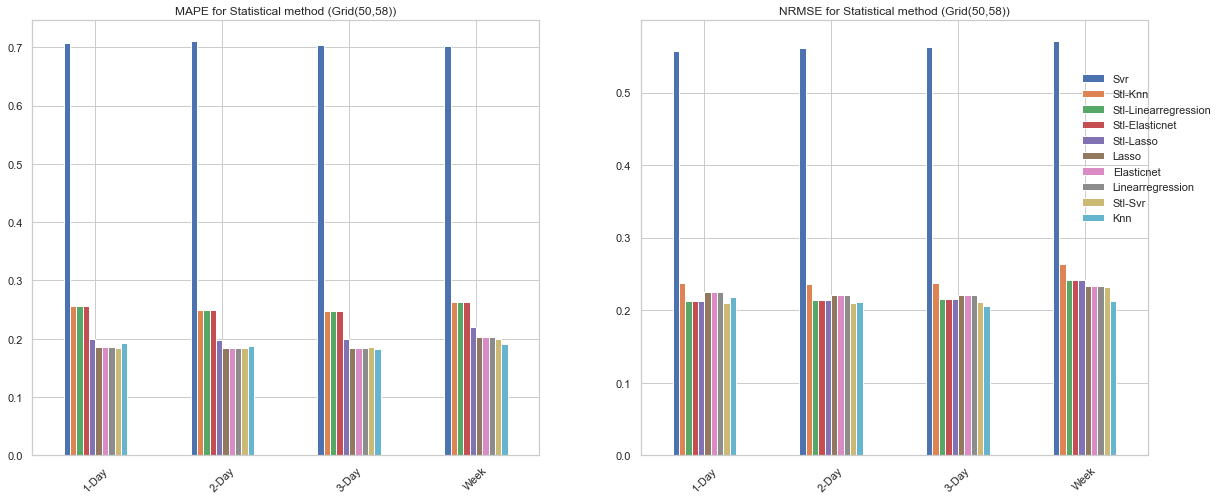

In [20]:
days = set(grids_ml_errors['Grid(50,58)'].columns.get_level_values(0))
figure, axes = plt.subplots(1, 2)
(
    pd.DataFrame([grids_ml_errors['Grid(50,58)'][d]['MAPE'] for d in days], index=days).T
    .sort_values('Week', ascending=False).T
    .plot(kind='bar',
          grid=True,
          ax=axes[0],
          rot='45',
          legend=False,
          layout=(4, 3),
          title='MAPE for Statistical method (Grid(50,58))',
          figsize=(20,8))
)
(
    pd.DataFrame([grids_ml_errors['Grid(50,58)'][d]['NRMSE'] for d in days], index=days).T
    .sort_values('Week', ascending=False).T
    .plot(kind='bar',
          grid=True,
          ax=axes[1],
          rot='45',
          layout=(4, 3),
          title='NRMSE for Statistical method (Grid(50,58))',
          figsize=(20,8))
    .legend(bbox_to_anchor=(0.85,0.9))
);

###### Box plot for Grid's Errors

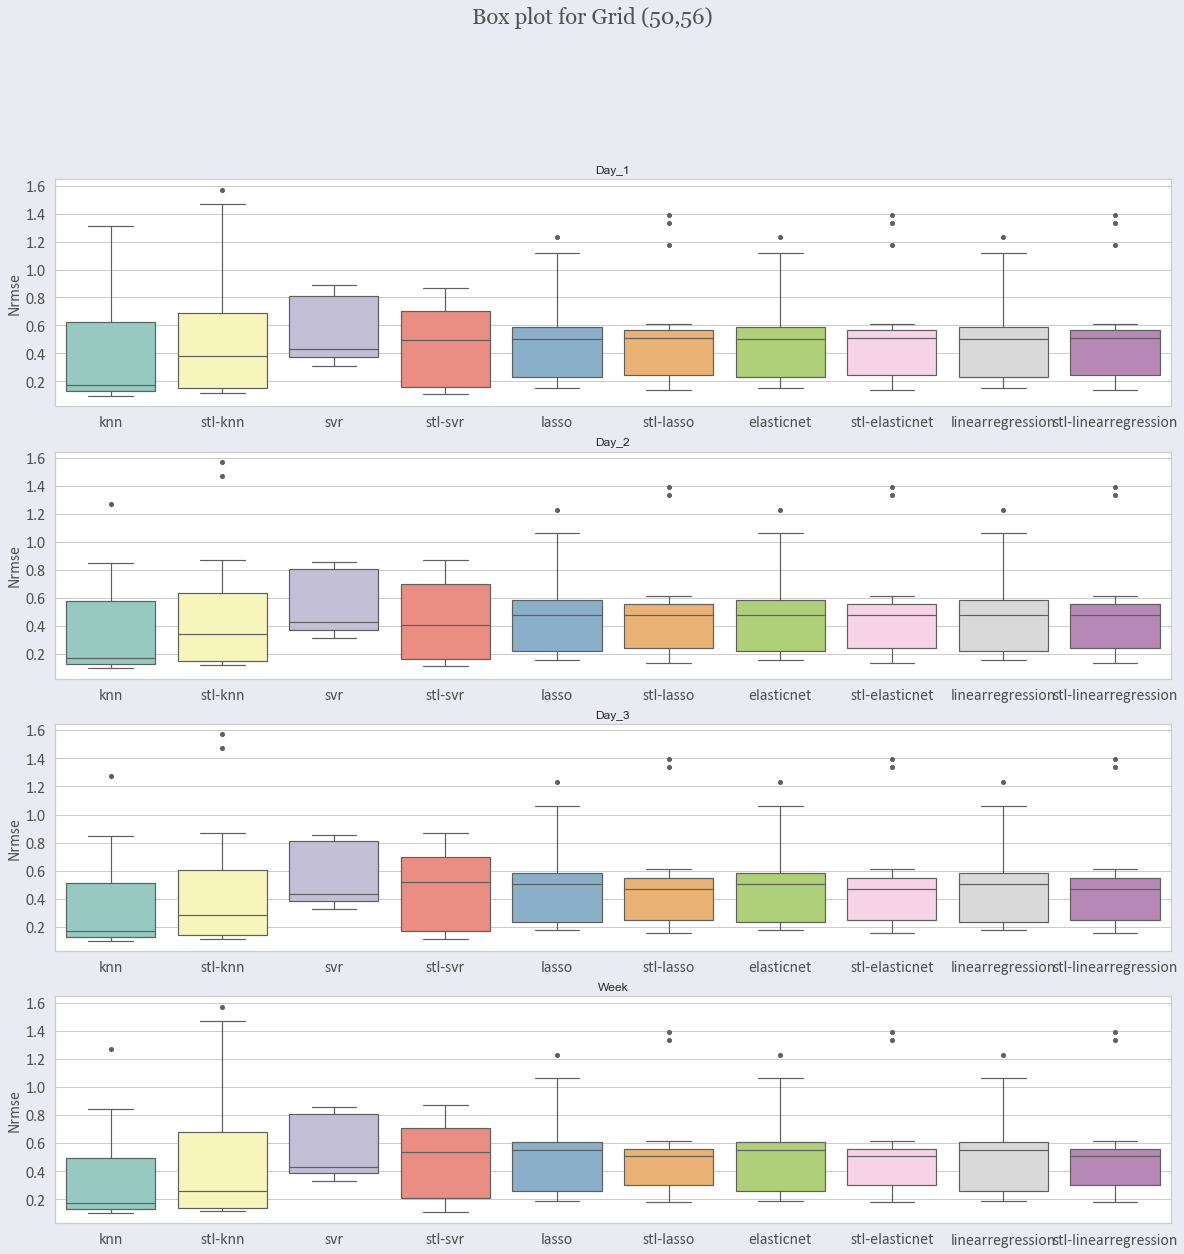

In [22]:
errors_box(ML_Results, (50,56), 'nrmse')

======================================== Grid(50,56) ========================================
                                    =====  Week  ======                                    


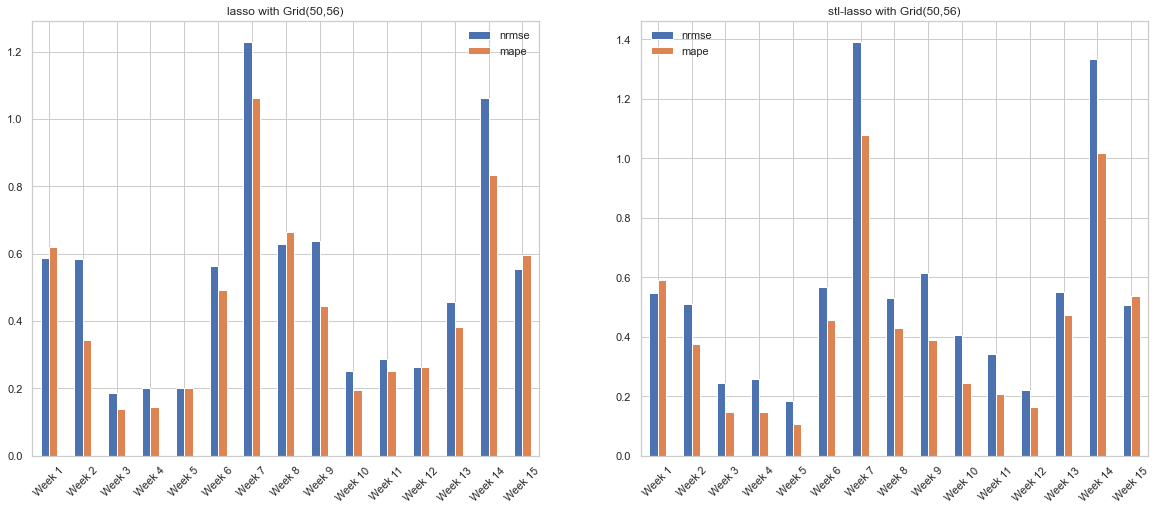

======================================== Grid(50,56) ========================================
                                    =====  Week  ======                                    


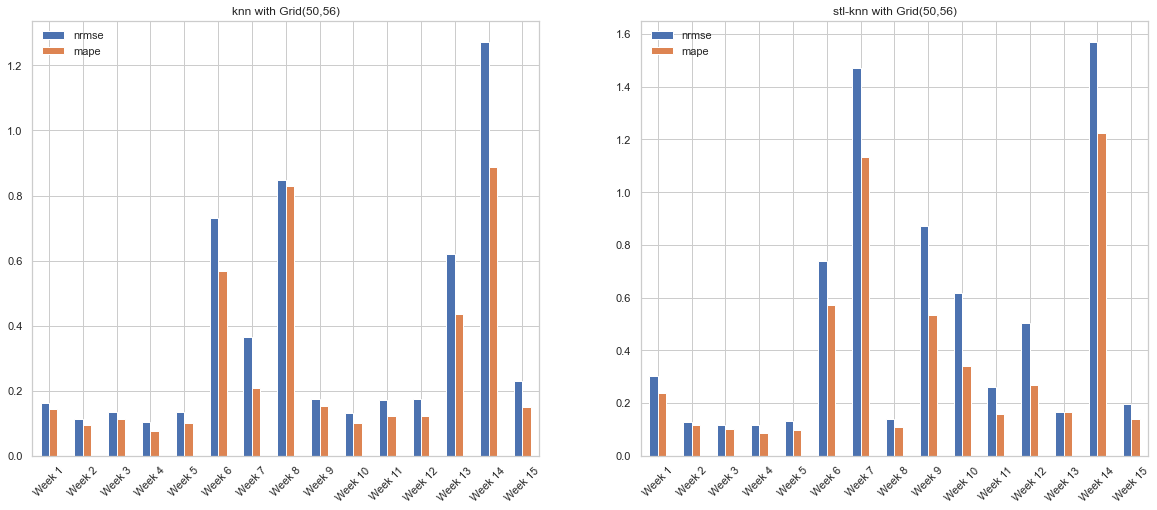

======================================== Grid(50,56) ========================================
                                    =====  Week  ======                                    


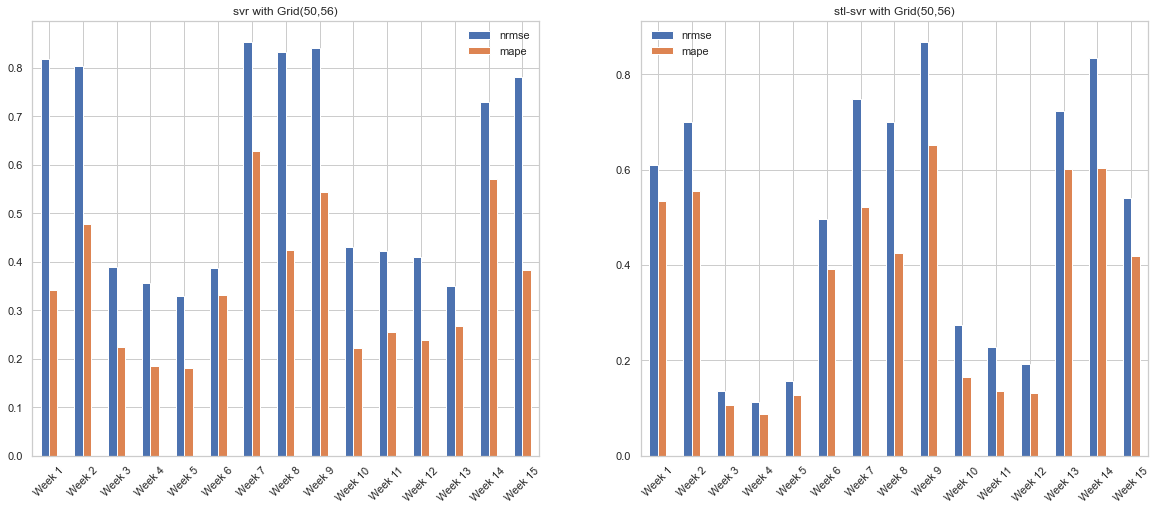

======================================== Grid(50,56) ========================================
                                    =====  Week  ======                                    


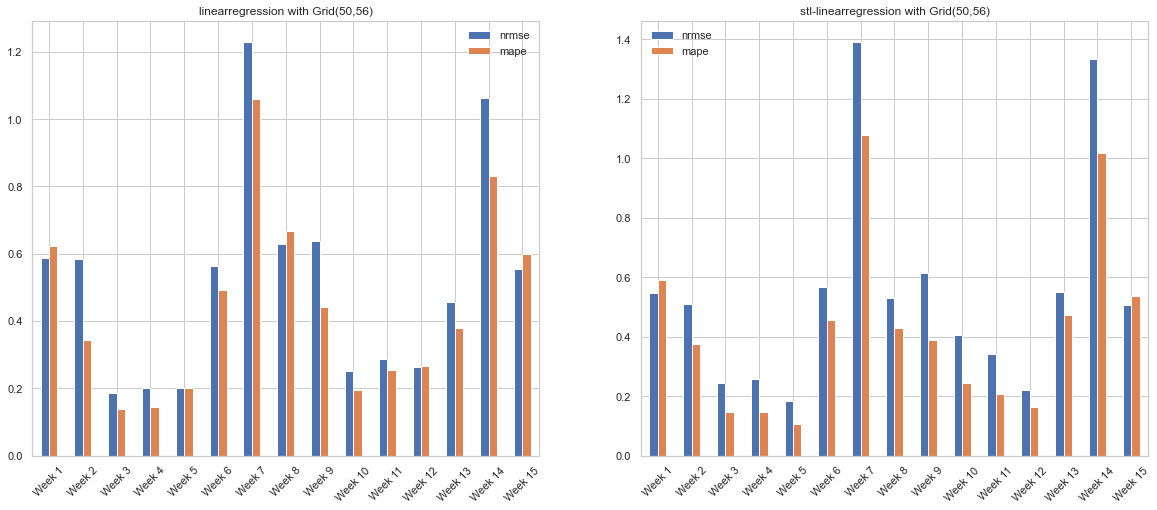

In [23]:
plot_errors(ML_Results, 'Week', ['lasso','stl-lasso'], ['Grid(50,56)'])
plot_errors(ML_Results, 'Week', ['knn','stl-knn'], ['Grid(50,56)'])
plot_errors(ML_Results, 'Week', ['svr','stl-svr'], ['Grid(50,56)'])
plot_errors(ML_Results, 'Week', ['linearregression','stl-linearregression'], ['Grid(50,56)'])

### Compare STAT & ML results

In [24]:
errors = pd.concat([grids_stat_errors['Grid(50,56)'], grids_ml_errors['Grid(50,56)']])

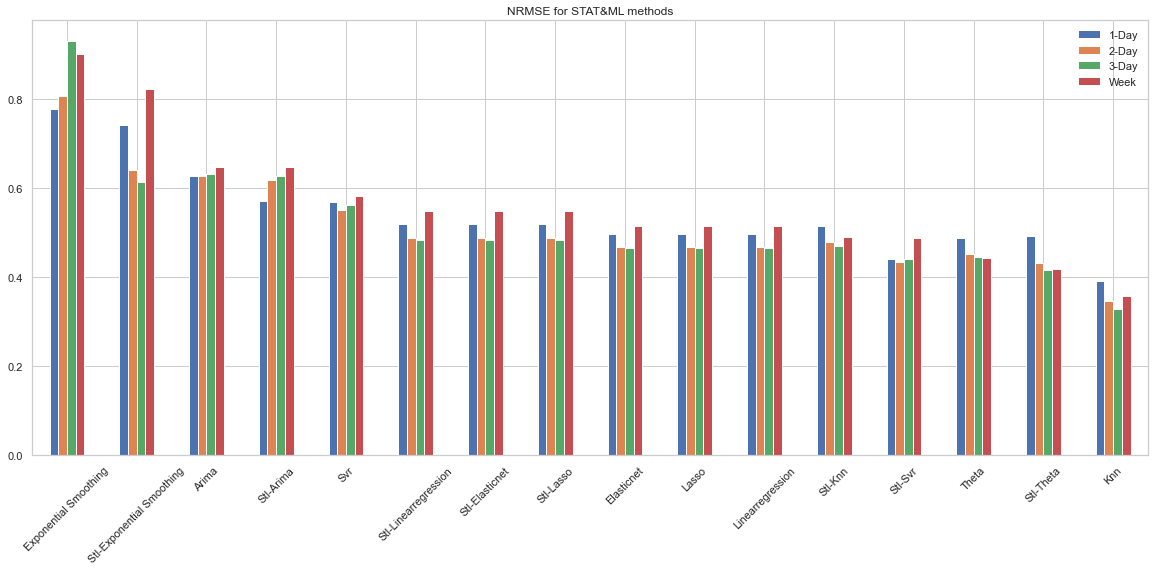

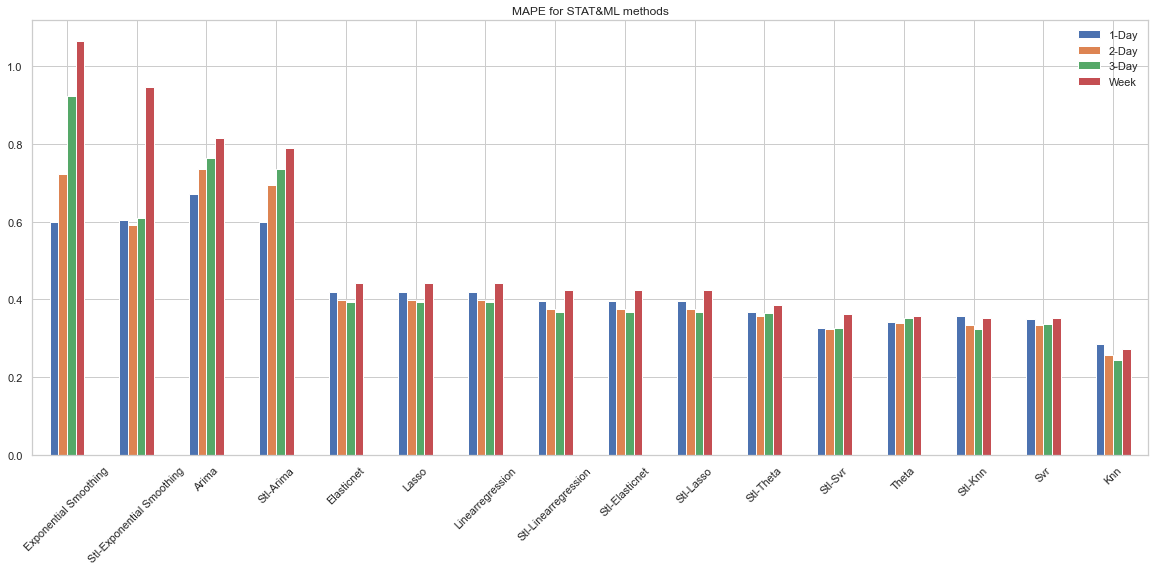

In [28]:
days = set(errors.columns.get_level_values(0))
(
    pd.DataFrame([errors[day]['NRMSE'] for day in days], index=days).T
    .sort_values('Week', ascending=False)
    .plot(kind='bar', 
          title='NRMSE for STAT&ML methods',
          rot='45',
          figsize=(20,8))
)
(
    pd.DataFrame([errors[day]['MAPE'] for day in days], index=days).T
    .sort_values('Week', ascending=False)
    .plot(kind='bar', 
          title='MAPE for STAT&ML methods',
          rot='45',
          figsize=(20,8))
);

### Deep Learninig algorithms

**We will try:**
- MLP
- CNN
- LSTM
- LSTM with CNN ( CNN-LSTM & ConvLSTM )

In [29]:
window_size = 30
date_iter = (full_data.shape[0]//144) - window_size
day_1 = date_iter - 1

models = ['mlp','stl-mlp',
          'cnn','stl-cnn']

DL_Results = {'Grid(%d,%d)'%(grid[0], grid[1]):
              {'%s'%model : 
               {'Day_1':{'%d'%(i+1):{'results':None, 'errors':None} for i in range(day_1)},
                'Day_2':{'%d'%(i+1):{'results':None, 'errors':None} for i in range(day_1-1)},
                'Day_3':{'%d'%(i+1):{'results':None, 'errors':None} for i in range(day_1-2)},
                'Week' :{'%d'%(i+1):{'results':None, 'errors':None} for i in range(day_1-6)}}
               for model in models}
              for grid in forecast_grids}

with catch_warnings():
    
    filterwarnings("ignore")
    
    for grid in forecast_grids[0:1]:
        
        print('='*50)            
        print('================== Grid (%d , %d) ================'%(grid[0], grid[1]))
        print('='*50)
        
        # gathering the data for each grid
        df = grids_df['Grid(%d,%d)'%(grid[0], grid[1])]
        
        # iterating over the last 32 days
        for i in range(0, date_iter-1, 1):
            # sliding window
            print('        ','='*30,'        ')            
            print('==================== Window %d ===================='%(i+1))
            print('        ','='*30,'        \n')
            
            # divide the data
            data = divide_data(i, df, day_1)
            # decomposition
            decomposition = STL(data['Training']['Target'], period=7*144).fit()
            seasonal, trend, resid = decomposition.seasonal, decomposition.trend, decomposition.resid
            
            # forecast only (trend + noise)
            data['Training']['Seasonal'] = seasonal
            data['Training']['Trend_Noise'] = trend + resid
            
            #### 1-Day forecasting
            print(str('='*30).center(50))            
            print('====== 1-Day  ======'.center(50))
            print(str('='*30).center(50),'\n') 
            
            #MLP
            print('====== MLP  ======'.center(50))
            DL_Results = dl_train_forecast(Create_Univariate_Multi_Step_MLP(data['Training']['Target']),
                                           None, None, 'mlp', data, 'Day_1',  i, DL_Results, grid,
                                           dict(n_steps_in=15, n_steps_out=144, units=128, scale=True, 
                                                epochs=100, lr=0.0002,batch=32, verbose=0), None, None)
                    
            print(' ==== STL-MLP =====\n'.center(50))
            s_model = Create_Univariate_Multi_Step_MLP(data['Training']['Seasonal'])
            tn_model = Create_Univariate_Multi_Step_MLP(data['Training']['Trend_Noise'])
            DL_Results = dl_train_forecast(None, s_model, tn_model, 'stl-mlp', data, 'Day_1', i, DL_Results, grid, None,
                                           dict(n_steps_in=15, n_steps_out=144, units=128, scale=True, epochs=100, 
                                                lr=0.0002,batch=32, verbose=0),
                                           dict(n_steps_in=15, n_steps_out=144, units=128, scale=True, epochs=100, 
                                                lr=0.0002,batch=32, verbose=0))
            
            #CNN
            print('====== CNN  ======'.center(50))
            DL_Results = dl_train_forecast(Create_Univariate_Multi_Step_CNN(data['Training']['Target']),
                                           None, None, 'cnn', data, 'Day_1',  i, DL_Results, grid,
                                           dict(n_steps_in=15, n_steps_out=144, units=128, scale=True, 
                                                epochs=100, lr=0.0002,batch=32, verbose=0), None, None)
                    
            print(' ==== STL-CNN =====\n'.center(50))
            s_model = Create_Univariate_Multi_Step_CNN(data['Training']['Seasonal'])
            tn_model = Create_Univariate_Multi_Step_CNN(data['Training']['Trend_Noise'])
            model = dl_train_forecast(None, s_model, tn_model, 'stl-cnn', data, 'Day_1', i, DL_Results, grid, None,
                                      dict(n_steps_in=15, n_steps_out=144, units=128, scale=True, epochs=100, 
                                           lr=0.0002,batch=32, verbose=0),
                                      dict(n_steps_in=15, n_steps_out=144, units=128, scale=True, epochs=100, 
                                           lr=0.0002,batch=32, verbose=0))
            
            #### 2-Day forecasting
            if i < (day_1-1):
                print(str('='*30).center(50))            
                print('====== 2-Day  ======'.center(50))
                print(str('='*30).center(50),'\n')
                #MLP
                print('====== MLP  ======'.center(50))
                DL_Results = dl_train_forecast(Create_Univariate_Multi_Step_MLP(data['Training']['Target']),
                                               None, None, 'mlp', data, 'Day_2',  i, DL_Results, grid,
                                               dict(n_steps_in=15, n_steps_out=2*144, units=128, scale=True, 
                                                    epochs=100, lr=0.0002,batch=32, verbose=0), None, None)

                print(' ==== STL-MLP =====\n'.center(50))
                s_model = Create_Univariate_Multi_Step_MLP(data['Training']['Seasonal'])
                tn_model = Create_Univariate_Multi_Step_MLP(data['Training']['Trend_Noise'])
                model = dl_train_forecast(None, s_model, tn_model, 'stl-mlp', data, 'Day_2', i, DL_Results, grid, None,
                                          dict(n_steps_in=15, n_steps_out=2*144, units=128, scale=True, epochs=100, 
                                               lr=0.0002,batch=32, verbose=0),
                                          dict(n_steps_in=15, n_steps_out=2*144, units=128, scale=True, epochs=100, 
                                               lr=0.0002,batch=32, verbose=0))

                #CNN
                print('====== CNN  ======'.center(50))
                DL_Results = dl_train_forecast(Create_Univariate_Multi_Step_CNN(data['Training']['Target']),
                                               None, None, 'cnn', data, 'Day_2',  i, DL_Results, grid,
                                               dict(n_steps_in=15, n_steps_out=2*144, units=128, scale=True, 
                                                    epochs=100, lr=0.0002,batch=32, verbose=0), None, None)

                print(' ==== STL-CNN =====\n'.center(50))
                s_model = Create_Univariate_Multi_Step_CNN(data['Training']['Seasonal'])
                tn_model = Create_Univariate_Multi_Step_CNN(data['Training']['Trend_Noise'])
                model = dl_train_forecast(None, s_model, tn_model, 'stl-cnn', data, 'Day_2', i, DL_Results, grid, None,
                                          dict(n_steps_in=15, n_steps_out=2*144, units=128, scale=True, epochs=100, 
                                               lr=0.0002,batch=32, verbose=0),
                                          dict(n_steps_in=15, n_steps_out=2*144, units=128, scale=True, epochs=100, 
                                               lr=0.0002,batch=32, verbose=0))
            #### 3-Day forecasting
            if i < (day_1-2):
                print(str('='*30).center(50))            
                print('====== 3-Day  ======'.center(50))
                print(str('='*30).center(50),'\n')
                #MLP
                print('====== MLP  ======'.center(50))
                DL_Results = dl_train_forecast(Create_Univariate_Multi_Step_MLP(data['Training']['Target']),
                                               None, None, 'mlp', data, 'Day_3',  i, DL_Results, grid,
                                               dict(n_steps_in=15, n_steps_out=3*144, units=128, scale=True, 
                                                    epochs=100, lr=0.0002,batch=32, verbose=0), None, None)

                print(' ==== STL-MLP =====\n'.center(50))
                s_model = Create_Univariate_Multi_Step_MLP(data['Training']['Seasonal'])
                tn_model = Create_Univariate_Multi_Step_MLP(data['Training']['Trend_Noise'])
                model = dl_train_forecast(None, s_model, tn_model, 'stl-mlp', data, 'Day_3', i, DL_Results, grid, None,
                                          dict(n_steps_in=15, n_steps_out=3*144, units=128, scale=True, epochs=100, 
                                               lr=0.0002,batch=32, verbose=0),
                                          dict(n_steps_in=15, n_steps_out=3*144, units=128, scale=True, epochs=100, 
                                               lr=0.0002,batch=32, verbose=0))

                #CNN
                print('====== CNN  ======'.center(50))
                DL_Results = dl_train_forecast(Create_Univariate_Multi_Step_CNN(data['Training']['Target']),
                                               None, None, 'cnn', data, 'Day_3',  i, DL_Results, grid,
                                               dict(n_steps_in=15, n_steps_out=3*144, units=128, scale=True, 
                                                    epochs=100, lr=0.0002,batch=32, verbose=0), None, None)

                print(' ==== STL-CNN =====\n'.center(50))
                s_model = Create_Univariate_Multi_Step_CNN(data['Training']['Seasonal'])
                tn_model = Create_Univariate_Multi_Step_CNN(data['Training']['Trend_Noise'])
                model = dl_train_forecast(None, s_model, tn_model, 'stl-cnn', data, 'Day_3', i, DL_Results, grid, None,
                                          dict(n_steps_in=15, n_steps_out=3*144, units=128, scale=True, epochs=100, 
                                               lr=0.0002,batch=32, verbose=0),
                                          dict(n_steps_in=15, n_steps_out=3*144, units=128, scale=True, epochs=100, 
                                               lr=0.0002,batch=32, verbose=0))
            #### week forecasting
            if i < (day_1-6):
                print(str('='*30).center(50))            
                print('====== Week  ======'.center(50))
                print(str('='*30).center(50),'\n') 
                #MLP
                print('====== MLP  ======'.center(50))
                DL_Results = dl_train_forecast(Create_Univariate_Multi_Step_MLP(data['Training']['Target']),
                                               None, None, 'mlp', data, 'Week',  i, DL_Results, grid,
                                               dict(n_steps_in=15, n_steps_out=7*144, units=128, scale=True, 
                                                    epochs=100, lr=0.0002,batch=32, verbose=0), None, None)

                print(' ==== STL-MLP =====\n'.center(50))
                s_model = Create_Univariate_Multi_Step_MLP(data['Training']['Seasonal'])
                tn_model = Create_Univariate_Multi_Step_MLP(data['Training']['Trend_Noise'])
                model = dl_train_forecast(None, s_model, tn_model, 'stl-mlp', data, 'Week', i, DL_Results, grid, None,
                                          dict(n_steps_in=15, n_steps_out=7*144, units=128, scale=True, epochs=100, 
                                               lr=0.0002,batch=32, verbose=0),
                                          dict(n_steps_in=15, n_steps_out=7*144, units=128, scale=True, epochs=100, 
                                               lr=0.0002,batch=32, verbose=0))

                #CNN
                print('====== CNN  ======'.center(50))
                DL_Results = dl_train_forecast(Create_Univariate_Multi_Step_CNN(data['Training']['Target']),
                                               None, None, 'cnn', data, 'Week',  i, DL_Results, grid,
                                               dict(n_steps_in=15, n_steps_out=7*144, units=128, scale=True, 
                                                    epochs=100, lr=0.0002,batch=32, verbose=0), None, None)

                print(' ==== STL-CNN =====\n'.center(50))
                s_model = Create_Univariate_Multi_Step_CNN(data['Training']['Seasonal'])
                tn_model = Create_Univariate_Multi_Step_CNN(data['Training']['Trend_Noise'])
                model = dl_train_forecast(None, s_model, tn_model, 'stl-cnn', data, 'Week', i, DL_Results, grid, None,
                                          dict(n_steps_in=15, n_steps_out=7*144, units=128, scale=True, epochs=100, 
                                               lr=0.0002,batch=32, verbose=0),
                                          dict(n_steps_in=15, n_steps_out=7*144, units=128, scale=True, epochs=100, 
                                               lr=0.0002,batch=32, verbose=0))

================== Grid (50 , 56) ================
==================== Window 1 ====================

               ====== 1-Day  ======               

                ====== MLP  ======                
                ==== STL-MLP =====
               
                ====== CNN  ======                
                ==== STL-CNN =====
               
               ====== 2-Day  ======               

                ====== MLP  ======                
                ==== STL-MLP =====
               
                ====== CNN  ======                
                ==== STL-CNN =====
               
               ====== 3-Day  ======               

                ====== MLP  ======                
                ==== STL-MLP =====
               
                ====== CNN  ======                
                ==== STL-CNN =====
               
               ====== Week  ======                

                ====== MLP  ======                
                ==== STL-M

In [15]:
# a_file = open("DL_Results.pkl", "wb")
# pickle.dump(DL_Results, a_file)
# a_file.close()
file = open("DL_Results.pkl", "rb")
DL_Results = pickle.load(file)
# print(Results)
file.close()

### Errors Visualization

###### Errors Table

In [16]:
grids_dl_errors = dict_to_dataframe(DL_Results, forecast_grids[0:1])
pd.set_option('display.float_format', '{:0.9}'.format)
grids_dl_errors['Grid(50,56)'].sort_values(by=('Week','MAPE'))

1-Day                   2-Day                   3-Day  \
               MAPE       NRMSE        MAPE       NRMSE        MAPE   
Cnn     0.486019875 0.596997253 0.506004827 0.648445575 0.492119091   
Mlp       0.4103973 0.592221626 0.441690346   0.6127602 0.466226184   
Stl-Cnn 0.490118992 0.603282989 0.500915328 0.652677564 0.487361062   
Stl-Mlp 0.422343369 0.601118104 0.479483536 0.638706181 0.516956158   

                           Week              
              NRMSE        MAPE       NRMSE  
Cnn     0.668691887 0.463734853 0.683088116  
Mlp     0.661296936 0.484950226 0.684261006  
Stl-Cnn 0.666769977 0.484997035 0.680532854  
Stl-Mlp 0.699565402 0.513033174 0.739242731

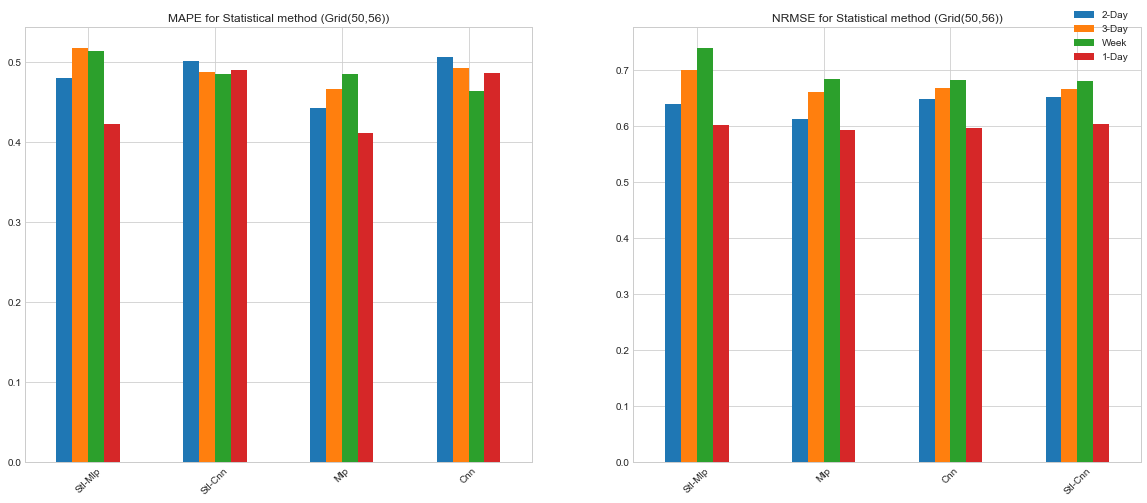

In [17]:
days = set(grids_dl_errors['Grid(50,56)'].columns.get_level_values(0))
figure, axes = plt.subplots(1, 2)
(
    pd.DataFrame([grids_dl_errors['Grid(50,56)'][d]['MAPE'] for d in days], index=days).T
    .sort_values('Week', ascending=False)
    .plot(kind='bar',
          grid=True,
          ax=axes[0],
          rot='45',
          legend=False,
          layout=(4, 3),
          title='MAPE for Statistical method (Grid(50,56))',
          figsize=(20,8))
)
(
    pd.DataFrame([grids_dl_errors['Grid(50,56)'][d]['NRMSE'] for d in days], index=days).T
    .sort_values('Week', ascending=False)
    .plot(kind='bar',
          grid=True,
          ax=axes[1],
          rot='45',
          layout=(4, 3),
          title='NRMSE for Statistical method (Grid(50,56))',
          figsize=(20,8))
    .legend(bbox_to_anchor=(0.85,0.9))
);

#### Box plot for Grid's Errors

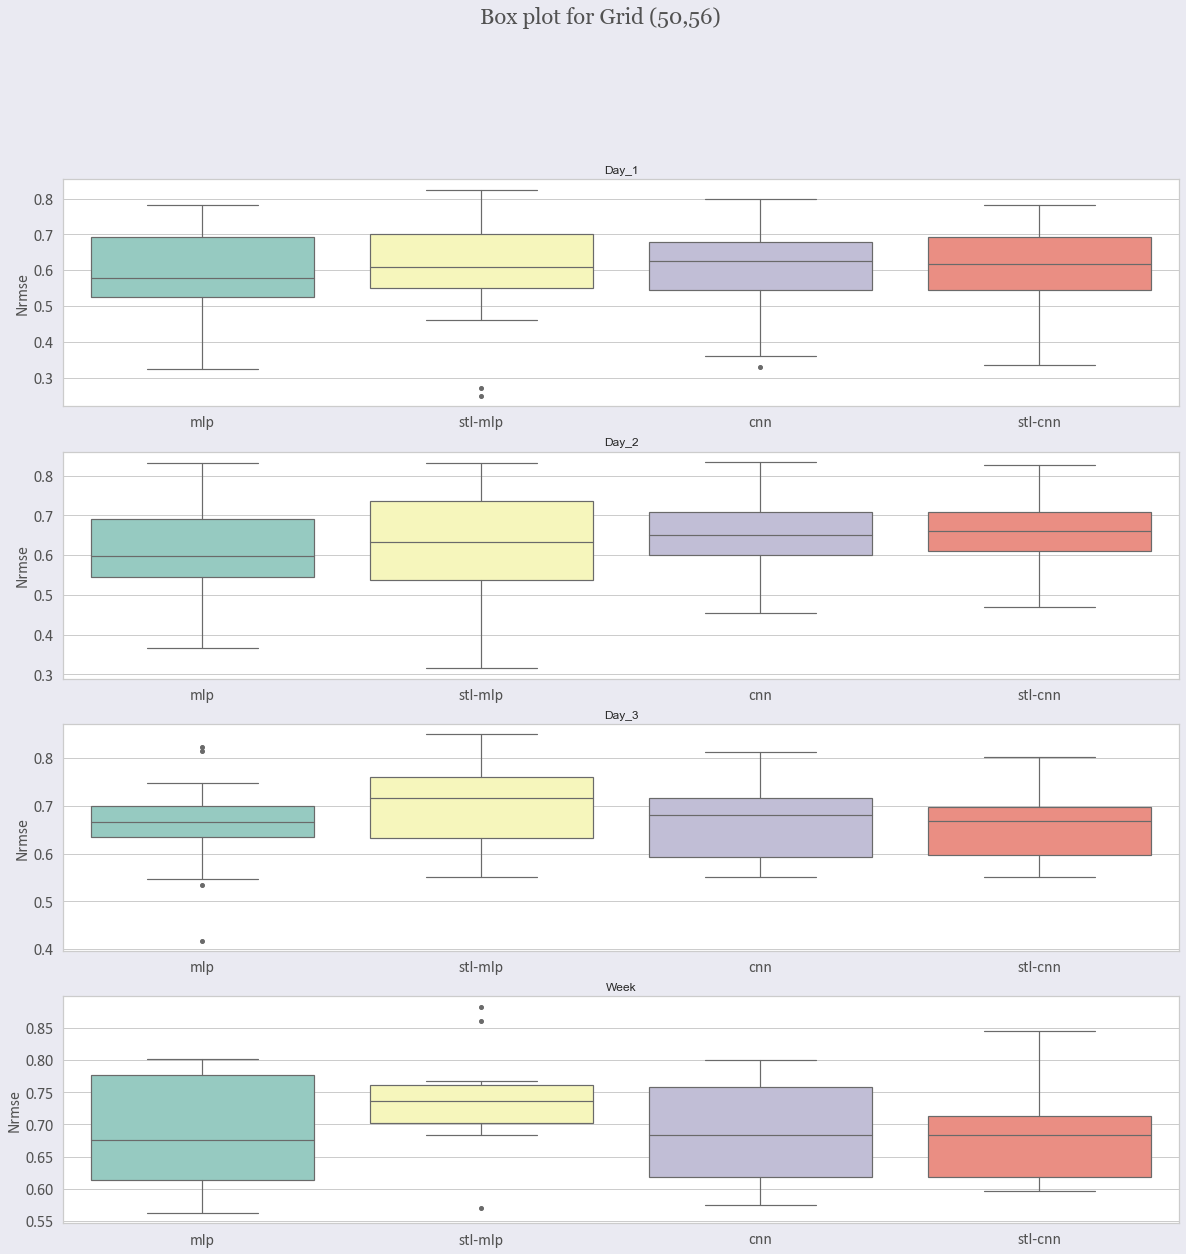

In [18]:
errors_box(DL_Results, (50,56), 'nrmse')

======================================== Grid(50,56) ========================================
                                    =====  Week  ======                                    


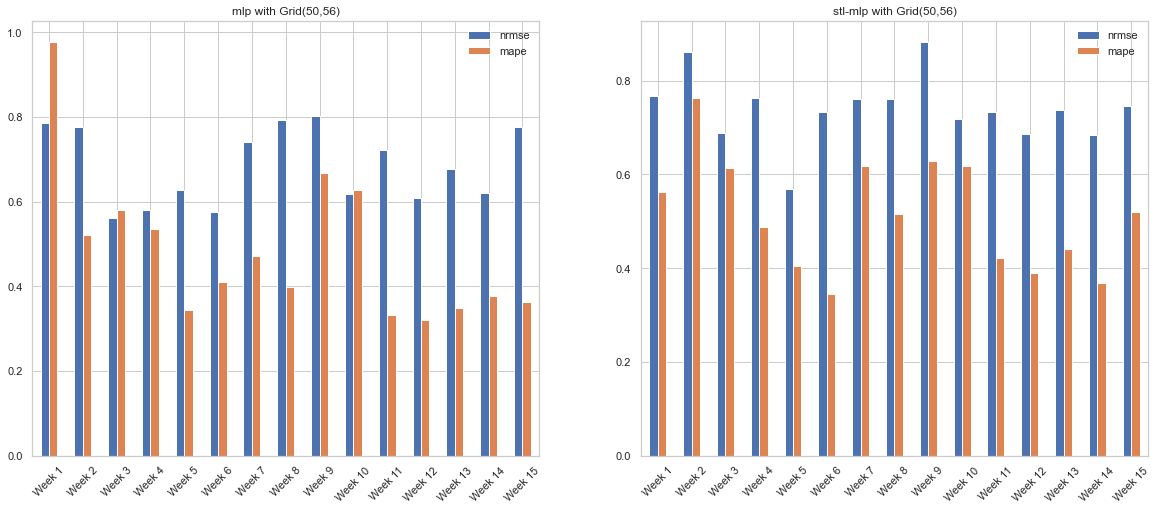

======================================== Grid(50,56) ========================================
                                    =====  Week  ======                                    


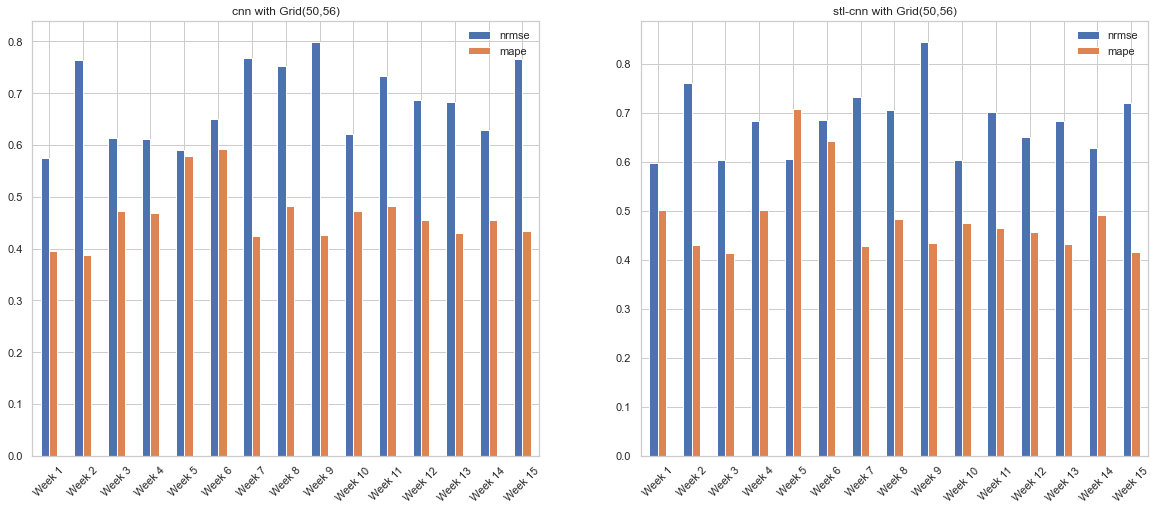

In [19]:
plot_errors(DL_Results, 'Week', ['mlp','stl-mlp'], ['Grid(50,56)'])
plot_errors(DL_Results, 'Week', ['cnn','stl-cnn'], ['Grid(50,56)'])

### Dealing with the data as a Panel data

Panel data is also called longitudinal data as it adds a temporal dimension to cross-sectional data.

The previous methods to solve this problem consider each grid as a `separate timeseries` and predict the future values of each timeseries using the past values of the same timeseries.

These methods ignores the `spacial dependency` of the traffic of one grid on the neighboring grids.

**Methods:**
- VAR
- PanelOLS
- RandomEffects
- BetweenOLS
- FirstDifferenceOLS
- PooledOLS
- FamaMacBeth
- Pooled coefficient estimator for panel data

#### Correlation
The basis behind Panel data forecasting is that each of the time series in the data influences each other.<br>
That is, you can predict the series with past values of itself along with other series in the system.<br>
So, we need to test this relationship before even building the models.

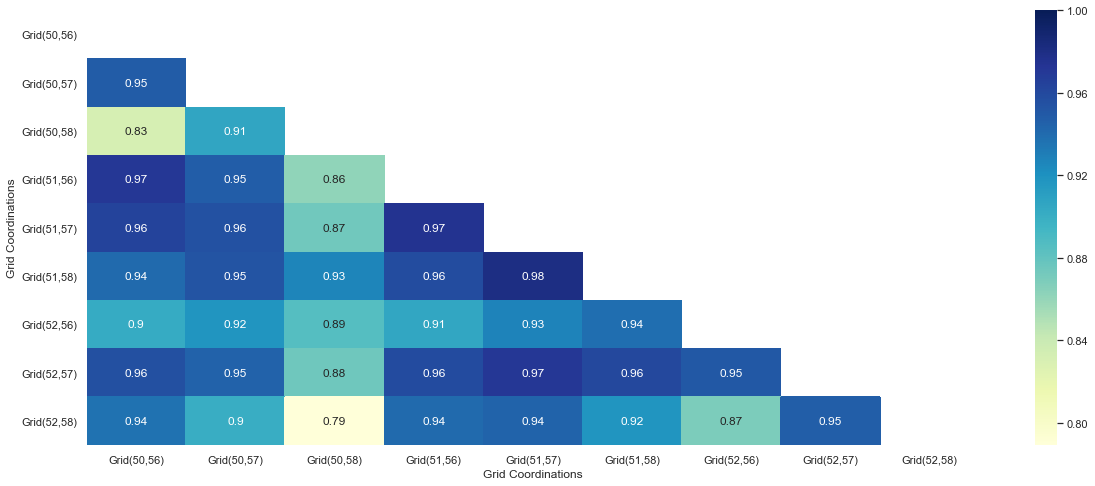

In [21]:
#correlation heatmap
corr = all_df.corr()
# creating the figure
plt.figure(figsize=(20,8))
# creating mask
mask = np.triu(np.ones_like(corr))
# plotting a triangle correlation heatmap
dataplot = sns.heatmap(corr, cmap="YlGnBu", annot=True, mask=mask)
plt.xlabel('Grid Coordinations')
plt.ylabel('Grid Coordinations');

#### VAR Model

In [23]:
window_size = 30
date_iter = (full_data.shape[0]//144) - window_size
day_1 = date_iter - 1

models = ['var','stl-var']

Panel_Results = {'Grid(%d,%d)'%(grid[0], grid[1]):
                 {'%s'%model : 
                  {'Day_1':{'%d'%(i+1):{'results':None, 'errors':None} for i in range(day_1)},
                   'Day_2':{'%d'%(i+1):{'results':None, 'errors':None} for i in range(day_1-1)},
                   'Day_3':{'%d'%(i+1):{'results':None, 'errors':None} for i in range(day_1-2)},
                   'Week' :{'%d'%(i+1):{'results':None, 'errors':None} for i in range(day_1-6)}}
                  for model in models}
                 for grid in forecast_grids}


with catch_warnings():

    filterwarnings("ignore")

    # iterating over the last 32 days
    for i in range(0, date_iter-1, 1):
        # sliding window
        print('        ','='*30,'        ')            
        print('==================== Window %d ===================='%(i+1))
        print('        ','='*30,'        \n')

        # divide the data
        data = divide_data(i, all_df, day_1)

#         #### 1-Day forecasting
        print(str('='*30).center(50))            
        print('====== 1-Day  ======'.center(50))
        print(str('='*30).center(50),'\n') 

        print('====== VAR  ======'.center(50))
        Panel_Results = VAR_model(data, Panel_Results, 'Day_1', 'var', i)

        print(' ==== STL-VAR =====\n'.center(50))
        Panel_Results = VAR_model(data, Panel_Results, 'Day_1', 'stl-var', i)

#         #### 2-Day forecasting
        if i < (day_1-1):
            print(str('='*30).center(50))            
            print('====== 2-Day  ======'.center(50))
            print(str('='*30).center(50),'\n')

            print('====== VAR  ======'.center(50))
            Panel_Results = VAR_model(data, Panel_Results, 'Day_2', 'var', i)

            print(' ==== STL-VAR =====\n'.center(50))
            Panel_Results = VAR_model(data, Panel_Results, 'Day_2', 'stl-var', i)

        #### 3-Day forecasting
        if i < (day_1-2):
            print(str('='*30).center(50))            
            print('====== 3-Day  ======'.center(50))
            print(str('='*30).center(50),'\n')

            print('====== VAR  ======'.center(50))
            Panel_Results = VAR_model(data, Panel_Results, 'Day_3', 'var', i)

            print(' ==== STL-VAR =====\n'.center(50))
            Panel_Results = VAR_model(data, Panel_Results, 'Day_3', 'stl-var', i)

        #### week forecasting
        if i < (day_1-6):
            print(str('='*30).center(50))            
            print('====== Week  ======'.center(50))
            print(str('='*30).center(50),'\n') 
            
            print('====== VAR  ======'.center(50))
            Panel_Results = VAR_model(data, Panel_Results, 'Week', 'var', i)

            print(' ==== STL-VAR =====\n'.center(50))
            Panel_Results = VAR_model(data, Panel_Results, 'Week', 'stl-var', i)

==================== Window 1 ====================

               ====== 1-Day  ======               

                ====== VAR  ======                
                ==== STL-VAR =====
               
               ====== 2-Day  ======               

                ====== VAR  ======                
                ==== STL-VAR =====
               
               ====== 3-Day  ======               

                ====== VAR  ======                
                ==== STL-VAR =====
               
               ====== Week  ======                

                ====== VAR  ======                
                ==== STL-VAR =====
               
==================== Window 2 ====================

               ====== 1-Day  ======               

                ====== VAR  ======                
                ==== STL-VAR =====
               
               ====== 2-Day  ======               

                ====== VAR  ======                
                ==== ST

In [24]:
# a_file = open("Panel_Results.pkl", "wb")
# pickle.dump(Panel_Results, a_file)
# a_file.close()
file = open("Panel_Results.pkl", "rb")
Panel_Results = pickle.load(file)
# print(Results)
file.close()

#### Error visualization

##### Table

In [25]:
grids_panel_errors = dict_to_dataframe(Panel_Results, forecast_grids)

In [26]:
pd.set_option('display.float_format', '{:1}'.format)
grids_panel_errors['Grid(50,56)']

1-Day                                 2-Day  \
                      MAPE              NRMSE               MAPE   
Var     0.4588198934089151  0.610843052607474 0.5976396331646894   
Stl-Var 0.5024369301981331 0.6075227421758365 0.5968374843428104   

                                        3-Day                     \
                     NRMSE               MAPE              NRMSE   
Var      0.646587218656961 0.6041202252559073 0.6625580017100902   
Stl-Var 0.6457889105185093 0.6041202252559073 0.6625580017100902   

                     Week                    
                     MAPE             NRMSE  
Var     0.740050394487978 0.660639940991039  
Stl-Var 0.740050394487978 0.660639940991039

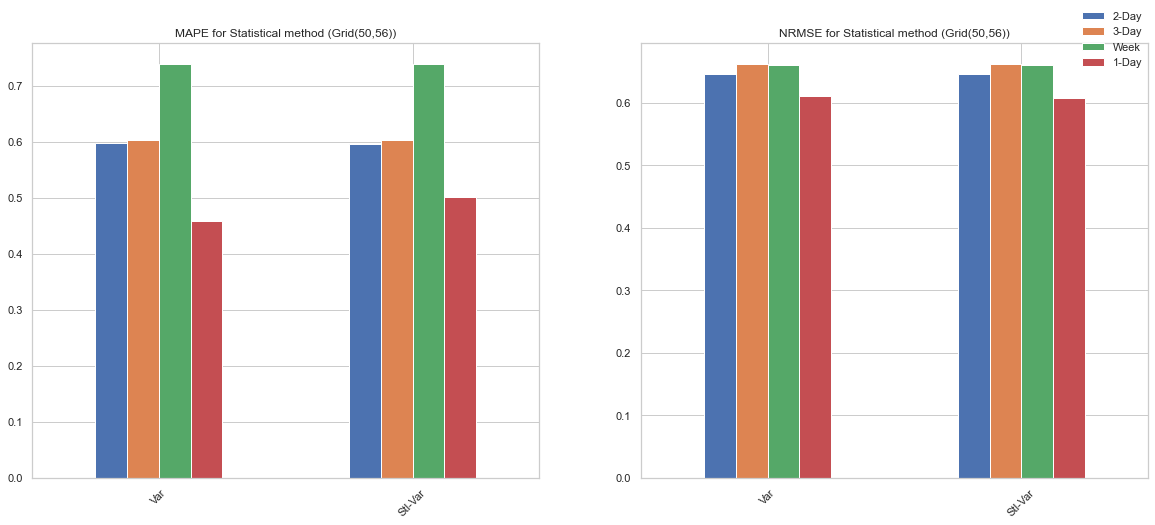

In [27]:
days = set(grids_panel_errors['Grid(50,56)'].columns.get_level_values(0))
figure, axes = plt.subplots(1, 2)
(
    pd.DataFrame([grids_panel_errors['Grid(50,56)'][d]['MAPE'] for d in days], index=days).T
    .sort_values('Week', ascending=False)
    .plot(kind='bar',
          grid=True,
          ax=axes[0],
          rot='45',
          legend=False,
          layout=(4, 3),
          title='MAPE for Statistical method (Grid(50,56))',
          figsize=(20,8))
)
(
    pd.DataFrame([grids_panel_errors['Grid(50,56)'][d]['NRMSE'] for d in days], index=days).T
    .sort_values('Week', ascending=False)
    .plot(kind='bar',
          grid=True,
          ax=axes[1],
          rot='45',
          layout=(4, 3),
          title='NRMSE for Statistical method (Grid(50,56))',
          figsize=(20,8))
    .legend(bbox_to_anchor=(0.85,0.92))
);

 #### Box plot for Grid's Errors

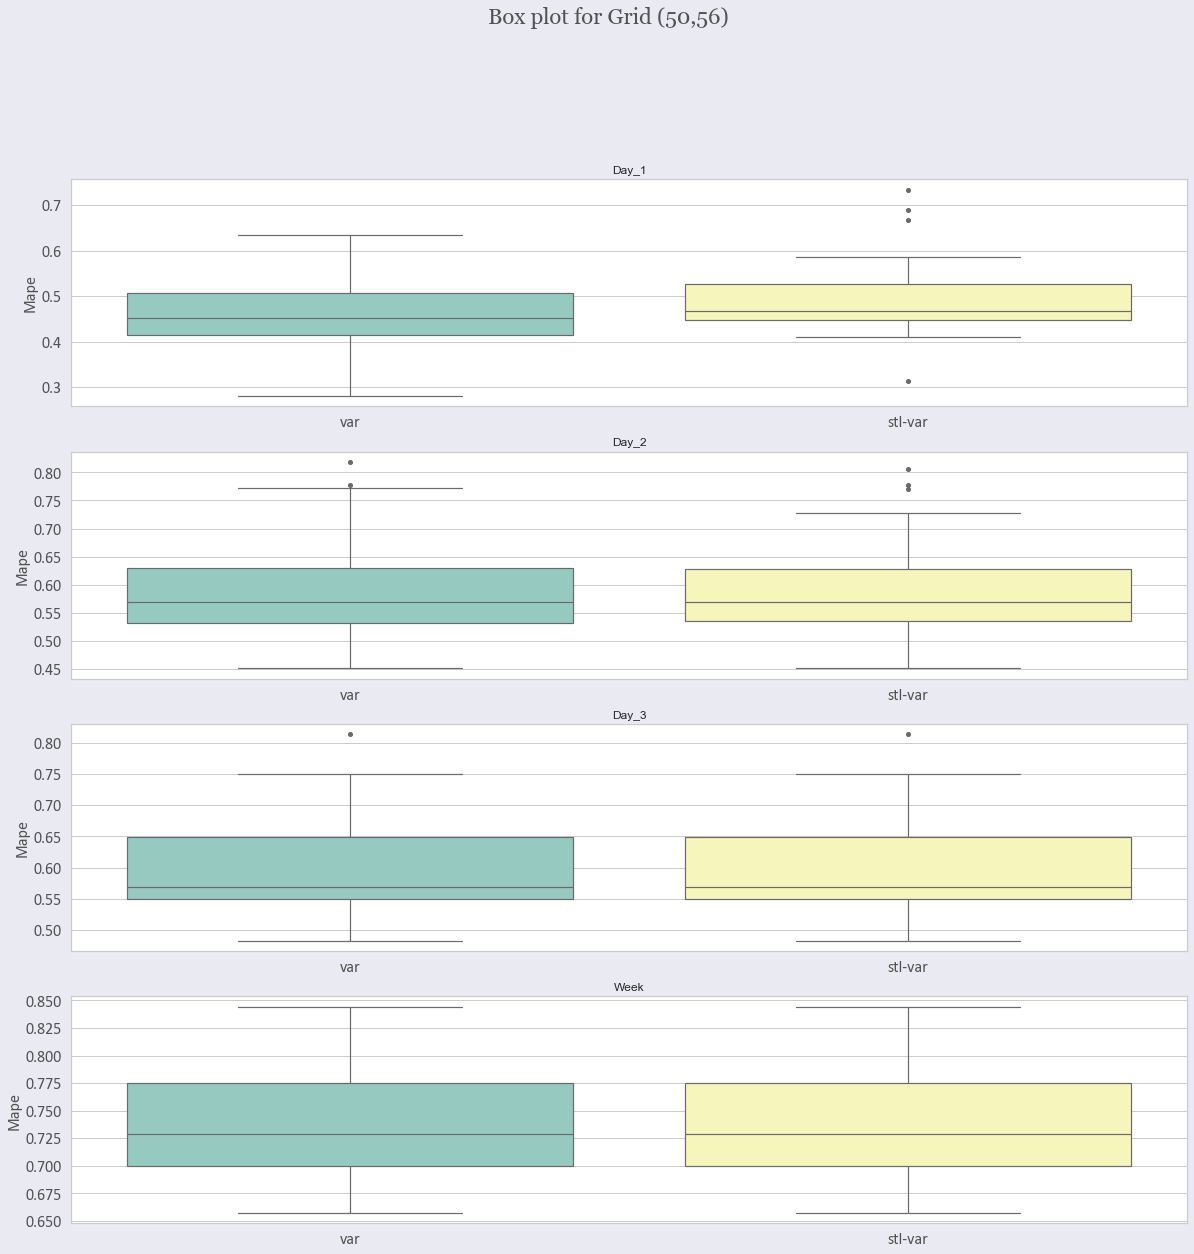

In [29]:
errors_box(Panel_Results, (50,56), 'mape')

======================================== Grid(50,56) ========================================
                                    =====  Day_1  ======                                    


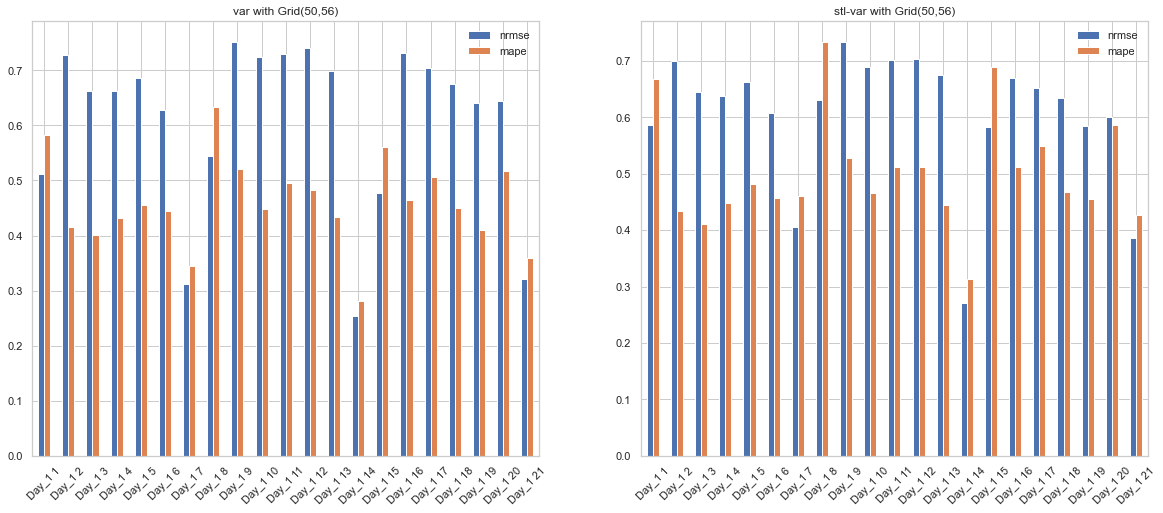

======================================== Grid(50,56) ========================================
                                    =====  Day_2  ======                                    


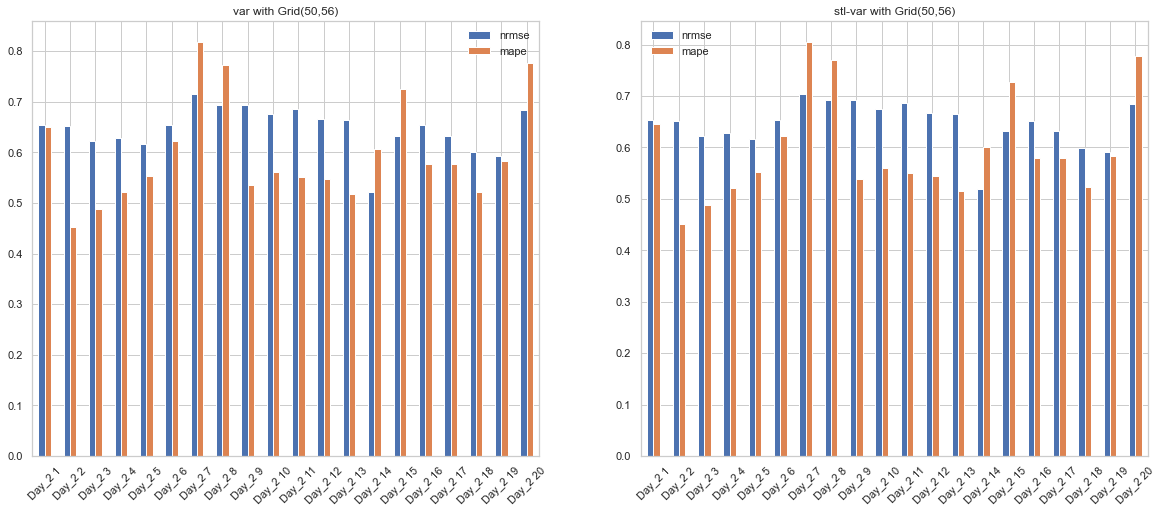

======================================== Grid(50,56) ========================================
                                    =====  Day_3  ======                                    


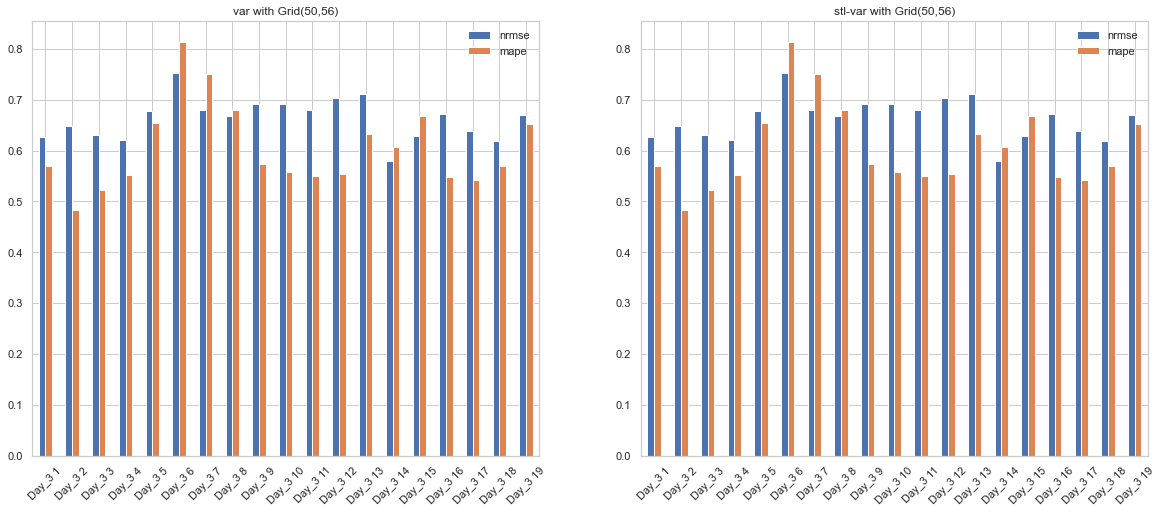

======================================== Grid(50,56) ========================================
                                    =====  Week  ======                                    


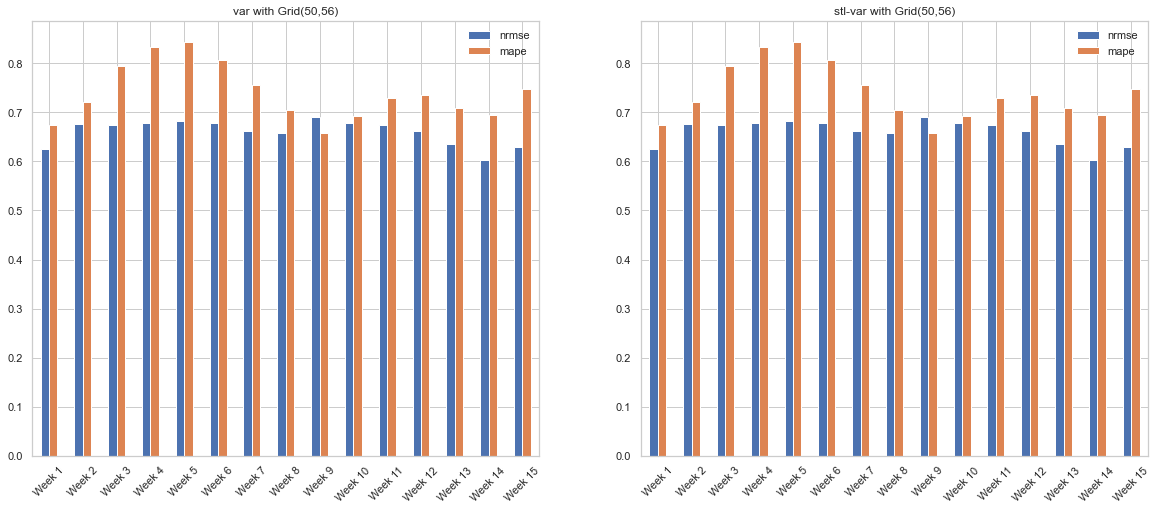

In [30]:
plot_errors(Panel_Results, 'Day_1', ['var','stl-var'], ['Grid(50,56)'])
plot_errors(Panel_Results, 'Day_2', ['var','stl-var'], ['Grid(50,56)'])
plot_errors(Panel_Results, 'Day_3', ['var','stl-var'], ['Grid(50,56)'])
plot_errors(Panel_Results, 'Week', ['var','stl-var'], ['Grid(50,56)'])